## 0.0 Imports

In [1]:
# !pip install inflection
# !pip install xgboost
# !pip install Boruta
# !pip install requests

In [2]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy import stats as ss
from boruta import BorutaPy
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from matplotlib.gridspec import GridSpec ##
import datetime ##
from sklearn.model_selection import cross_val_score ##
import json ##
import requests

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( "ignore" )

### 0.1 Helper Functions

In [3]:
# Cross-Validation para Time Series
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print("/nKFold Number: {}".format(k))

        # start and end date for validation
        validation_start_date = x_training["date"].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training["date"].max() - datetime.timedelta(days=(k - 1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training["date"] < validation_start_date]
        validation = x_training[(x_training["date"] >= validation_start_date) & (x_training["date"] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(["date", "sales"], axis=1)
        ytraining = training["sales"]
        
        # validation
        xvalidation = validation.drop(["date", "sales"], axis=1)
        yvalidation = validation["sales"]

        # model
        m = model.fit(xtraining, ytraining)  

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append(m_result["MAE"])
        mape_list.append(m_result["MAPE"])
        rmse_list.append(m_result["RMSE"])

    return pd.DataFrame({
        "Model Name": model_name,
        "MAE CV": np.round(np.mean(mae_list), 2).astype(str) + " +/- " + np.round(np.std(mae_list), 2).astype(str),
        "MAPE CV": np.round(np.mean(mape_list), 2).astype(str) + " +/- " + np.round(np.std(mape_list), 2).astype(str),
        "RMSE CV": np.round(np.mean(rmse_list), 2).astype(str) + " +/- " + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

def mean_percentage_error ( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error ( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { "Model Name": model_name,
    "MAE": mae,
    "MAPE": mape,
    "RMSE": rmse }, index=[0] )

def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( "bmh" )
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24
    display( HTML( "<style>.container { width:100% !important; }</style>") )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( "display.expand_frame_repr", False )
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv("Rossmann Store Sales/train.csv", low_memory=False)
df_store_raw = pd.read_csv("Rossmann Store Sales/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

## 1.0 Descrição dos Dados

In [6]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [7]:
#df1.columns
cols_old = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo","StateHoliday", "SchoolHoliday", "StoreType",
            "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2",
            "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]

snakecase = lambda x: inflection.underscore ( x )
cols_new = list (map (snakecase, cols_old))

#rename
df1.columns = cols_new

### 1.2 Data Dimensions

In [8]:
print ("Number of rows: {}".format(df1.shape[0]))
print ("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


### 1.3 Data Types

In [9]:
df1 ["date"] = pd.to_datetime (df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [10]:
df1.isna().sum() # 3 maneiras de tratar o NA. 1.Jogar fora, 2. usar algoritmos pra preencher, 3.Preencher após entender.

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [11]:
# competition_distance  -- Concorrente mais próximo
df1["competition_distance"] = df1["competition_distance"].apply (lambda x: 200000.0 if math.isnan (x) else x)

# competition_open_since_month -- Mês que o concorrente mais próximo foi aberto
df1["competition_open_since_month"] = df1.apply (lambda x: x["date"].month if math.isnan (x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

# competition_open_since_year  -- Ano que o concorrente mais próximo foi aberto
df1["competition_open_since_year"] = df1.apply (lambda x: x["date"].year if math.isnan (x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)
                        
# promo2_since_week -- Se teve continuação de uma promoção  
df1["promo2_since_week"] = df1.apply (lambda x: x["date"].week if math.isnan (x["promo2_since_week"]) else x["promo2_since_week"], axis=1)

# promo2_since_year               
df1["promo2_since_year"] = df1.apply (lambda x: x["date"].year if math.isnan (x["promo2_since_year"]) else x["promo2_since_year"], axis=1)

# promo_interval                  
month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True )
df1["month_map"] = df1["date"].dt.month.map( month_map )
df1["is_promo"] = df1[["promo_interval", "month_map"]].apply( lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split( "," ) else 0, axis=1 )

In [12]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
772623,714,4,2013-08-08,3153,252,1,0,0,1,d,c,12070.0,10.0,2005.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",Aug,0
7237,548,6,2015-07-25,4612,343,1,0,0,0,d,c,3760.0,2.0,2009.0,0,30.0,2015.0,0,Jul,0
1016143,49,2,2013-01-01,0,0,0,0,a,1,d,c,18010.0,9.0,2007.0,0,1.0,2013.0,0,Jan,0
64833,164,3,2015-06-03,8316,826,1,1,0,1,a,a,1160.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jun,0
460260,551,4,2014-05-15,5338,893,1,0,0,0,a,c,2190.0,9.0,2013.0,0,20.0,2014.0,0,May,0


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype (int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype (int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype (int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype (int)

### 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include = ["int32", "int64", "float64"] )
cat_attributes = df1.select_dtypes( exclude = ["int32", "int64", "float64", "datetime64[ns]"] )

### 1.7.1 Numerical Atributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew (distribuição em torno da média), kurtosis (distribuição é escarpada ou achatada)
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std","skew", "kurtosis"]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


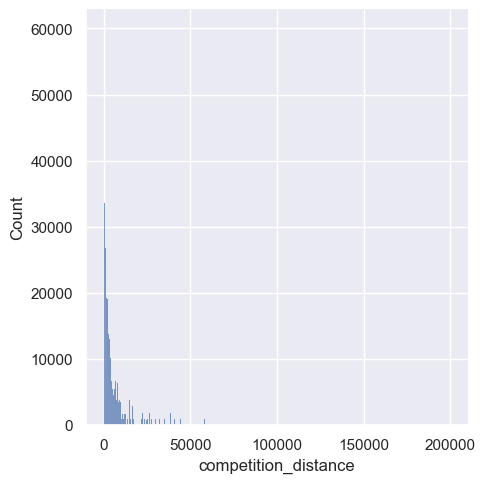

In [18]:
sns.displot(df1["competition_distance"], kde=False)
plt.show()

### 1.7.2 Categorical Atributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

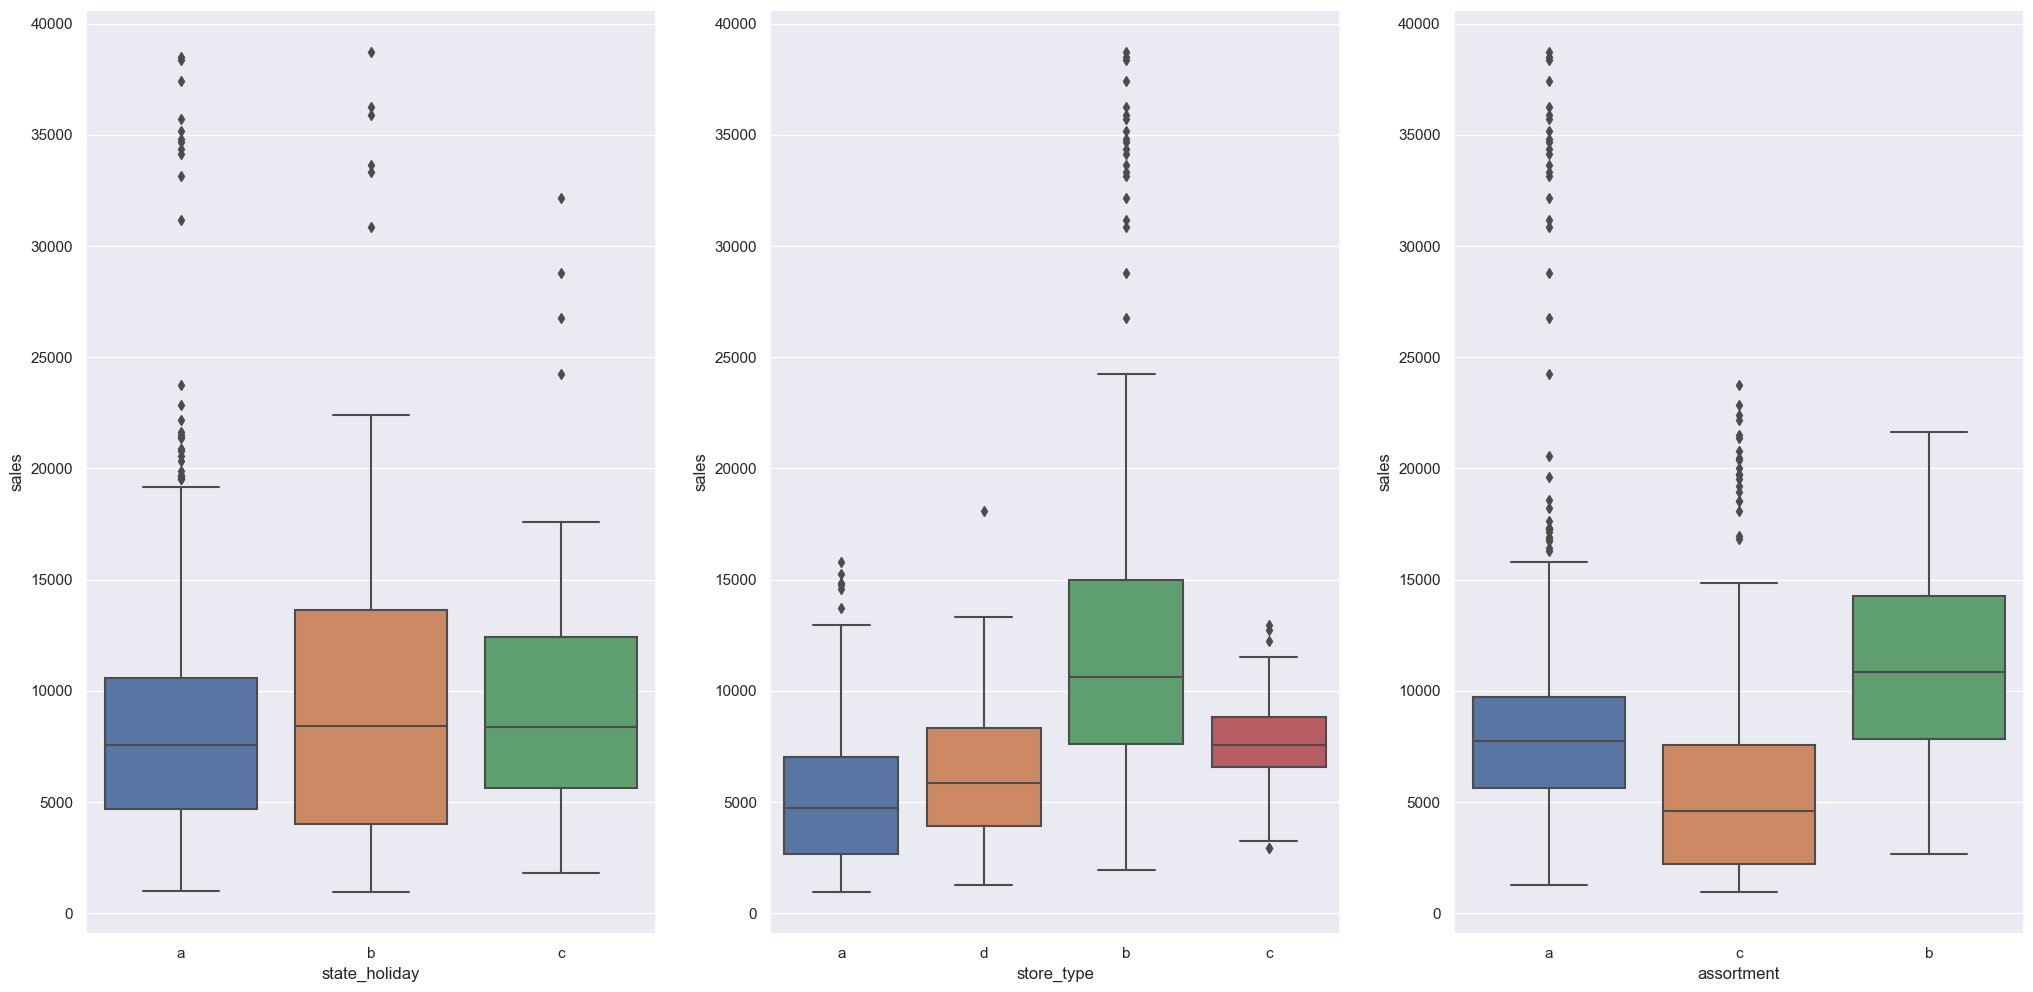

In [20]:
aux = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x="state_holiday", y="sales", data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x="store_type", y="sales", data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x="assortment", y="sales", data=aux )

plt.show()

## 2.0 - Feature Engineering

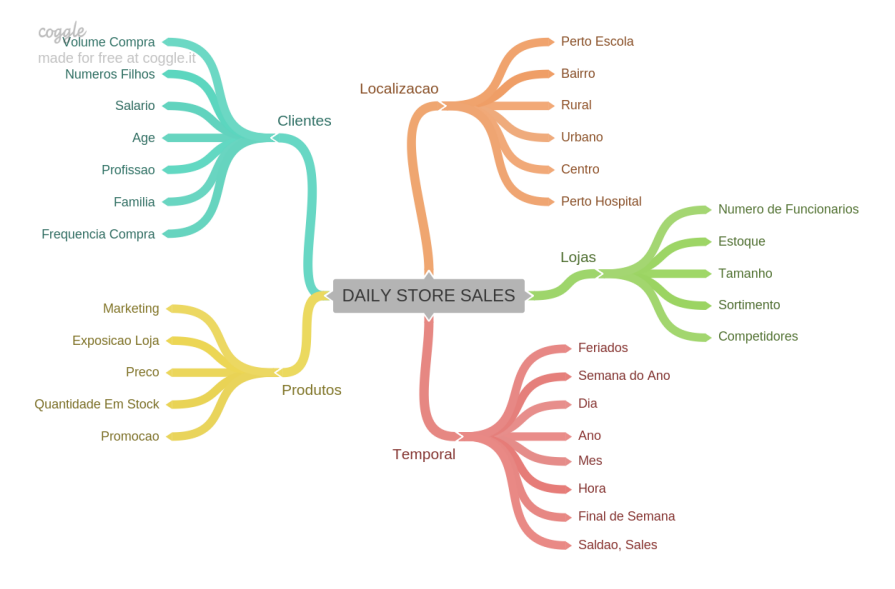

In [21]:
Image ("Images/MindMap.png")

### 2.2. Creating Hypotheses

In [22]:
df2 = df1.copy()

### 2.2.1. Hipoteses Loja

#### 1. Lojas com número maior de funcionários deveriam vender mais.
#### 2. Lojas com maior capacidade de estoque deveriam vender mais.
#### 3. Lojas com maior porte deveriam vender mais.
#### 4. Lojas com maior sortimentos deveriam vender mais.
#### 5. Lojas com competidores mais próximos deveriam vender menos.
#### 6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

#### 1. Lojas que investem mais em Marketing deveriam vender mais.
#### 2. Lojas com maior exposição de produto deveriam vender mais.
#### 3. Lojas com produtos com preço menor deveriam vender mais.
#### 5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
#### 6. Lojas com promoções ativas por mais tempo deveriam vender mais.
#### 7. Lojas com mais dias de promoção deveriam vender mais.
#### 8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

#### 1. Lojas abertas durante o feriado de Natal deveriam vender mais.
#### 2. Lojas deveriam vender mais ao longo dos anos.
#### 3. Lojas deveriam vender mais no segundo semestre do ano.
#### 4. Lojas deveriam vender mais depois do dia 10 de cada mês.
#### 5. Lojas deveriam vender menos aos finais de semana.
#### 6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3. Lista Final de Hipóteses

#### 1. Lojas com maior sortimentos deveriam vender mais.
#### 2. Lojas com competidores mais próximos deveriam vender menos.
#### 3. Lojas com competidores à mais tempo deveriam vendem mais.
#### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#### 5. Lojas com mais dias de promoção deveriam vender mais.
#### 7. Lojas com mais promoções consecutivas deveriam vender mais.
#### 8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#### 9. Lojas deveriam vender mais ao longo dos anos.
#### 10. Lojas deveriam vender mais no segundo semestre do ano.
#### 11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#### 12. Lojas deveriam vender menos aos finais de semana.
#### 13. Lojas deveriam vender menos durante os feriados escolares.

### 2.4. Feature Engineering

In [23]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
# df2["week_of_year"] = df2["date"].dt.weekofyear obsoleto
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# year week
df2["year_week"] = df2["date"].dt.strftime ("%Y-%W")


# competition since 
df2["competition_since"] = df2.apply (lambda x: datetime.datetime (year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) /30).apply ( lambda x: x.days).astype (int)

# promo since
df2["promo_since"] = df2["promo2_since_year"].astype (str) + "-" + df2["promo2_since_week"].astype (str)
df2["promo_since"] = df2["promo_since"].apply (lambda x: datetime.datetime.strptime (x + "-1", "%Y-%W-%w") - datetime.timedelta (days=7))
#.strptime(): Isso é um método da classe datetime que converte uma string em um objeto de data e hora.
df2["promo_time_week"] = ( ( df2["date"] - df2["promo_since"] )/7 ).apply(lambda x: x.days ).astype (int)

# assortment
df2["assortment"] = df2["assortment"].apply (lambda x: "basic" if x == "a" else"extra" if x == "b" else "extended")

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply (lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")


In [24]:
df2["week_of_year"] = df2["week_of_year"].astype (int)

In [25]:
df2.sample(5).T

,591504,97257,442092,670462,897285
store,225,253,223,18,496
day_of_week,5,2,6,4,4
date,2014-01-17 00:00:00,2015-05-05 00:00:00,2014-05-31 00:00:00,2013-11-07 00:00:00,2013-04-18 00:00:00
sales,4178,6395,6061,6618,5538
customers,516,735,632,726,716
open,1,1,1,1,1
promo,0,1,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,d,a,d,d,d


## 3.0 - Filtering of Variables

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1. Row Filtering

In [28]:
# Filtrei apenas o dias que estavam abertos, portanto != 0 e dias que teve vendas > 0
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

### 3.2. Column Selection

In [29]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop( cols_drop, axis=1 )

## 4.0. Exploratory Data Analysis (EDA)

In [30]:
df4 = df3.copy()

### 4.1. Univariate Analysis (Análise Univariada)

### 4.1.1. Response Variable

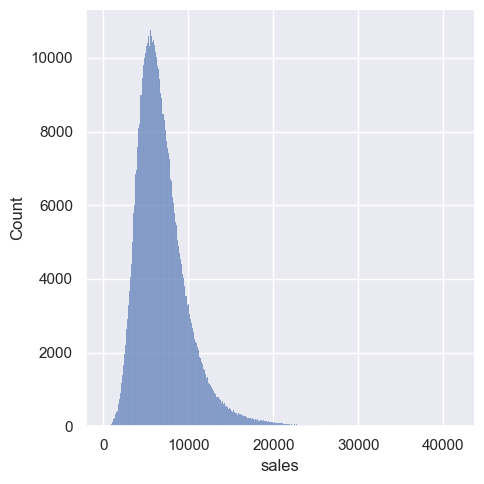

In [31]:
sns.displot(df4["sales"], kde=False)
plt.show()

 ### 4.1.2. Numerical Variable

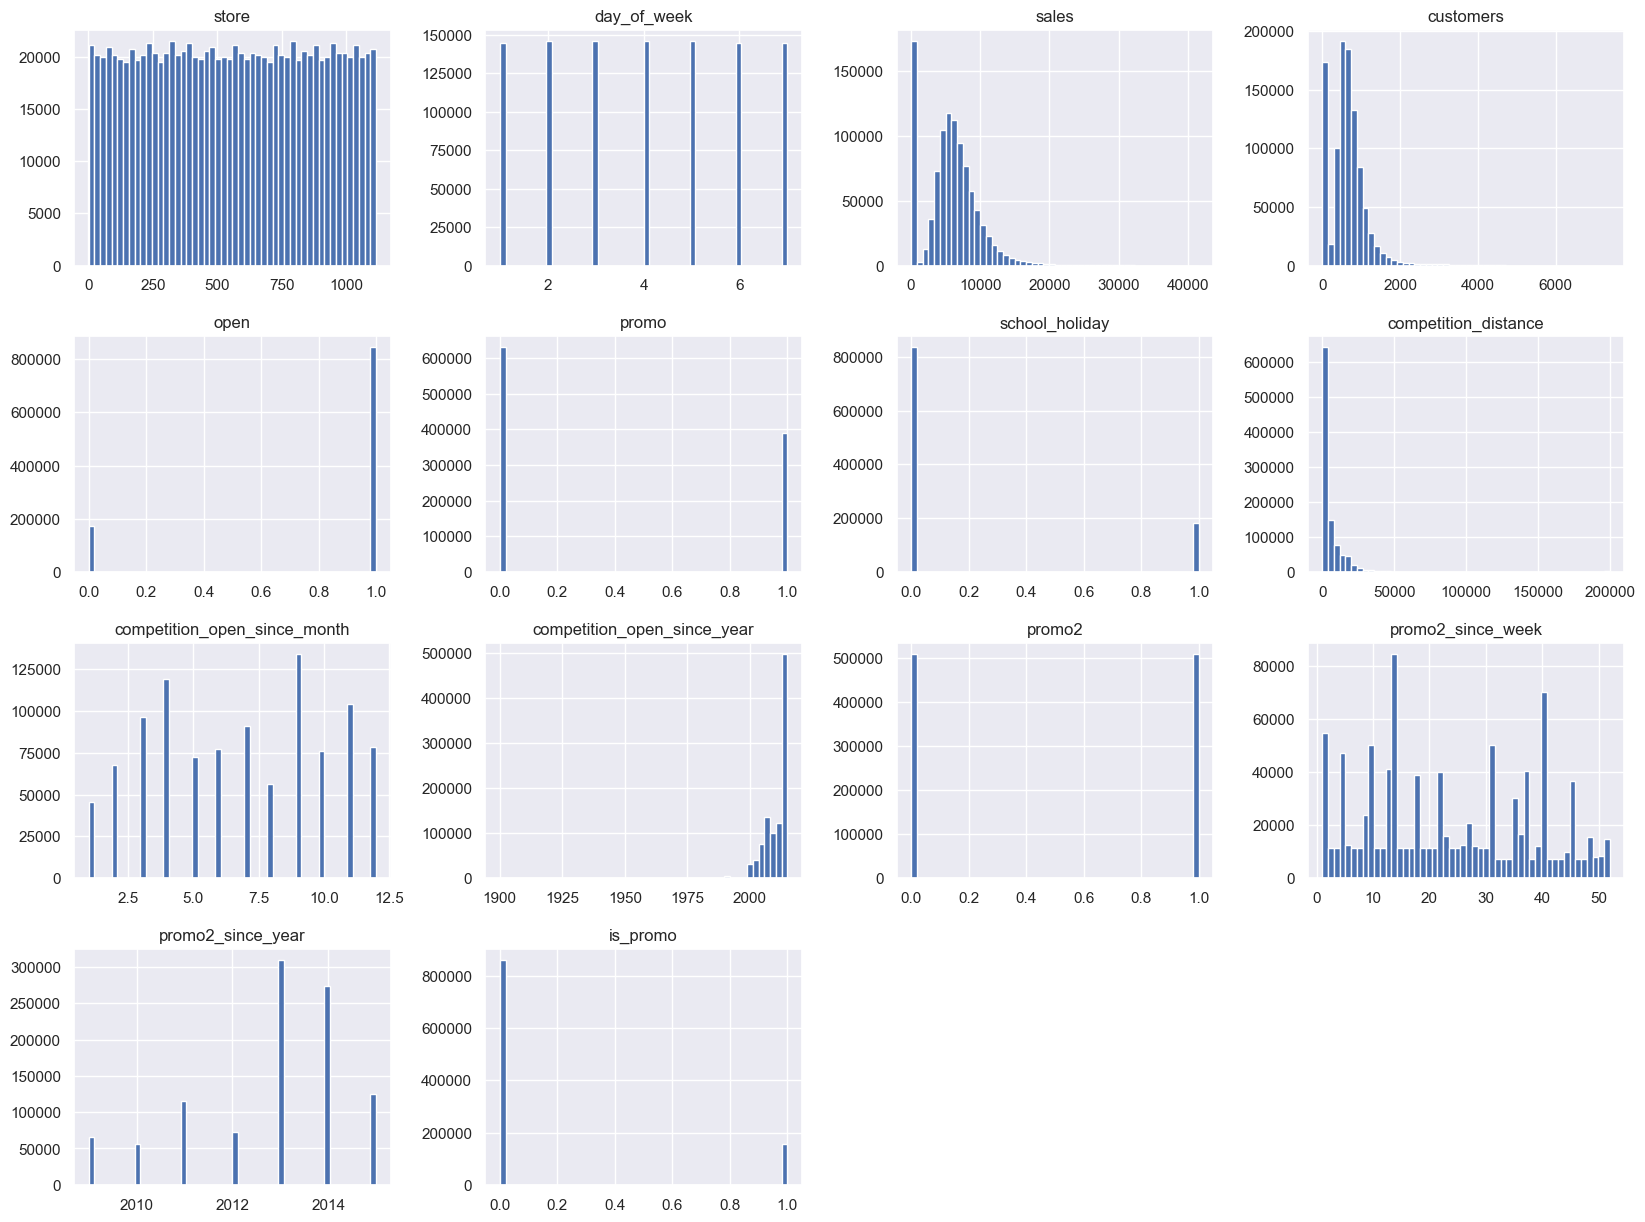

In [32]:
num_attributes.hist(bins=50, figsize=(20,15));
plt.show()

 ### 4.1.3. Categorical Variable

In [33]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


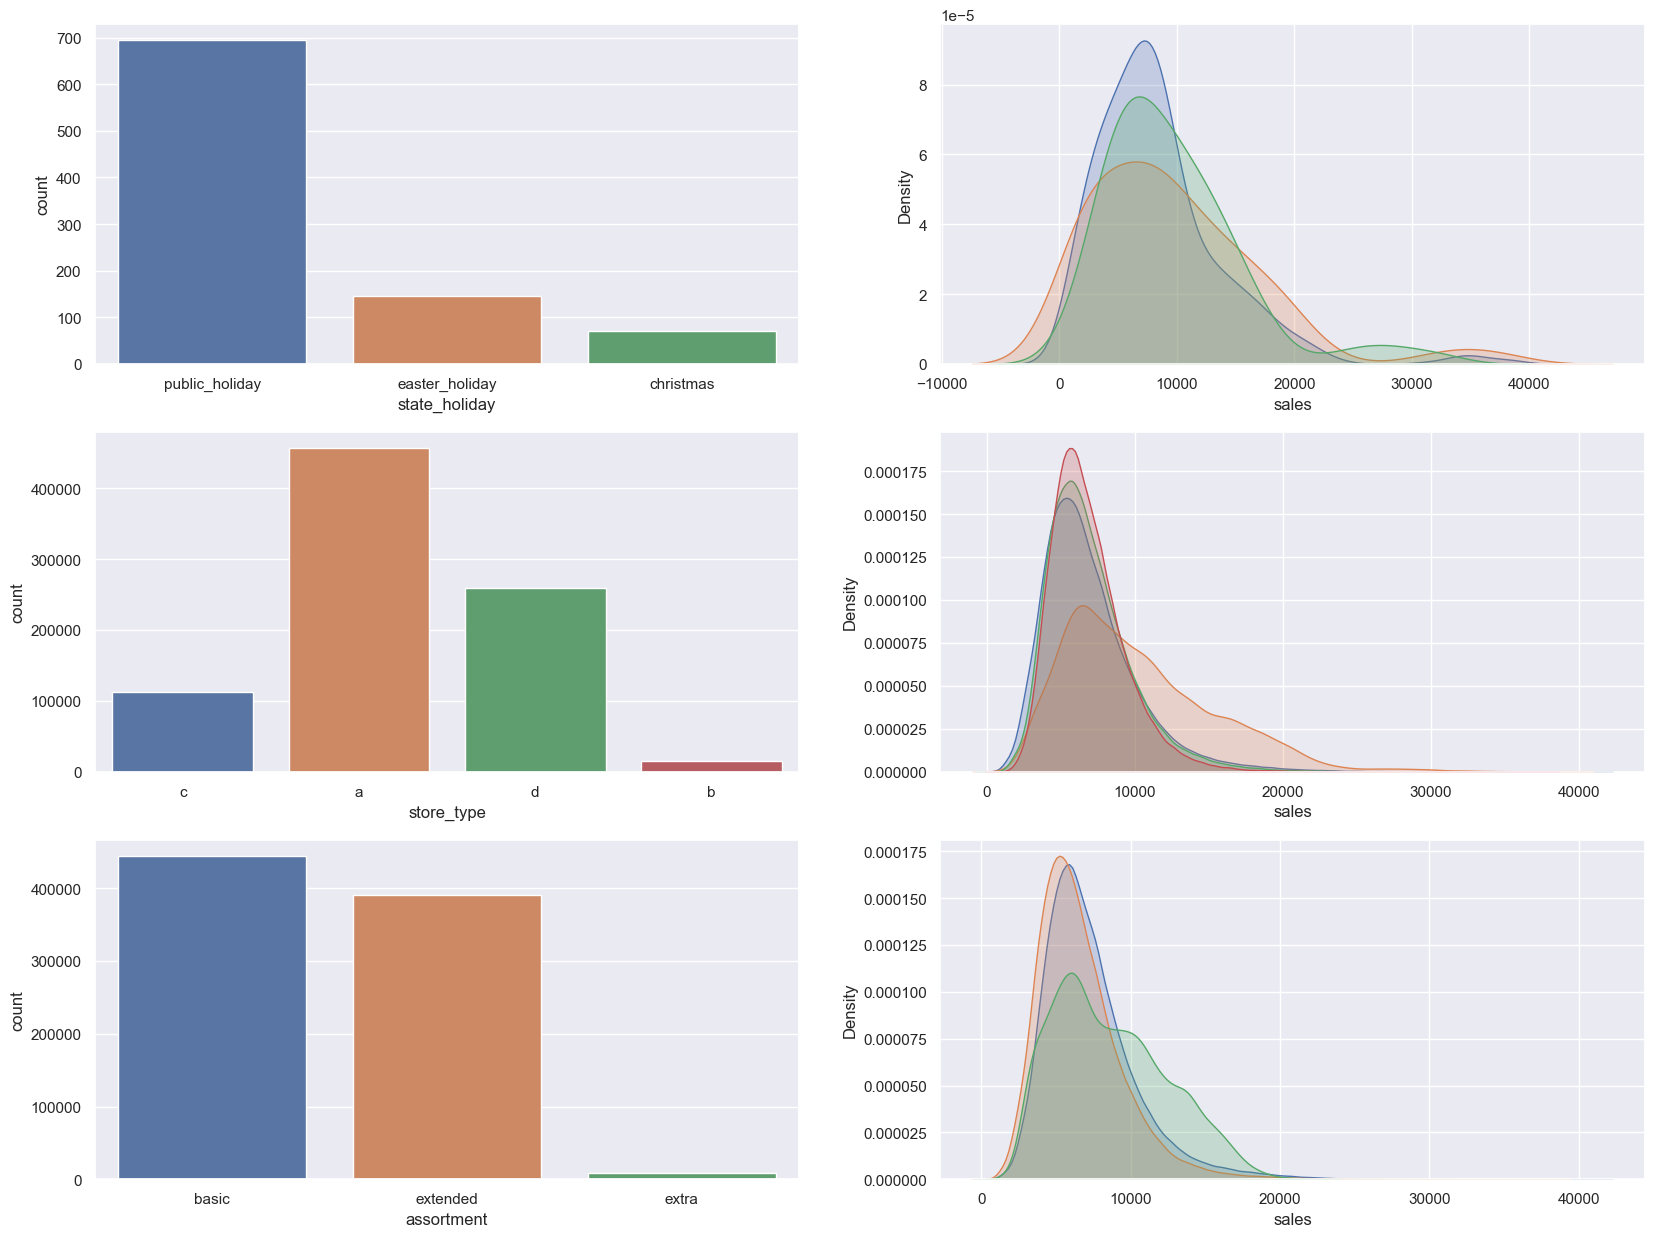

In [34]:
# state_holiday
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(data=a, x="state_holiday")

plt.subplot(3, 2, 2)
sns.kdeplot(data=df4[df4["state_holiday"] == "public_holiday"], x="sales", label="public_holiday", shade=True)
sns.kdeplot(data=df4[df4["state_holiday"] == "easter_holiday"], x="sales", label="easter_holiday", shade=True)
sns.kdeplot(data=df4[df4["state_holiday"] == "christmas"], x="sales", label="christmas", shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x="store_type")
plt.subplot(3, 2, 4)
sns.kdeplot(data=df4[df4["store_type"] == "a"], x="sales", label="a", shade=True)
sns.kdeplot(data=df4[df4["store_type"] == "b"], x="sales", label="b", shade=True)
sns.kdeplot(data=df4[df4["store_type"] == "c"], x="sales", label="c", shade=True)
sns.kdeplot(data=df4[df4["store_type"] == "d"], x="sales", label="d", shade=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot(data=df4, x="assortment")
plt.subplot( 3, 2, 6 )
sns.kdeplot(data=df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True )
sns.kdeplot(data=df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True )
sns.kdeplot(data=df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True )

plt.show()

### 4.2. Bivariate Analysis (Análise Bivariada)

### 4.2.1 H1. Lojas com maior sortimentos deveriam vender mais.
FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.

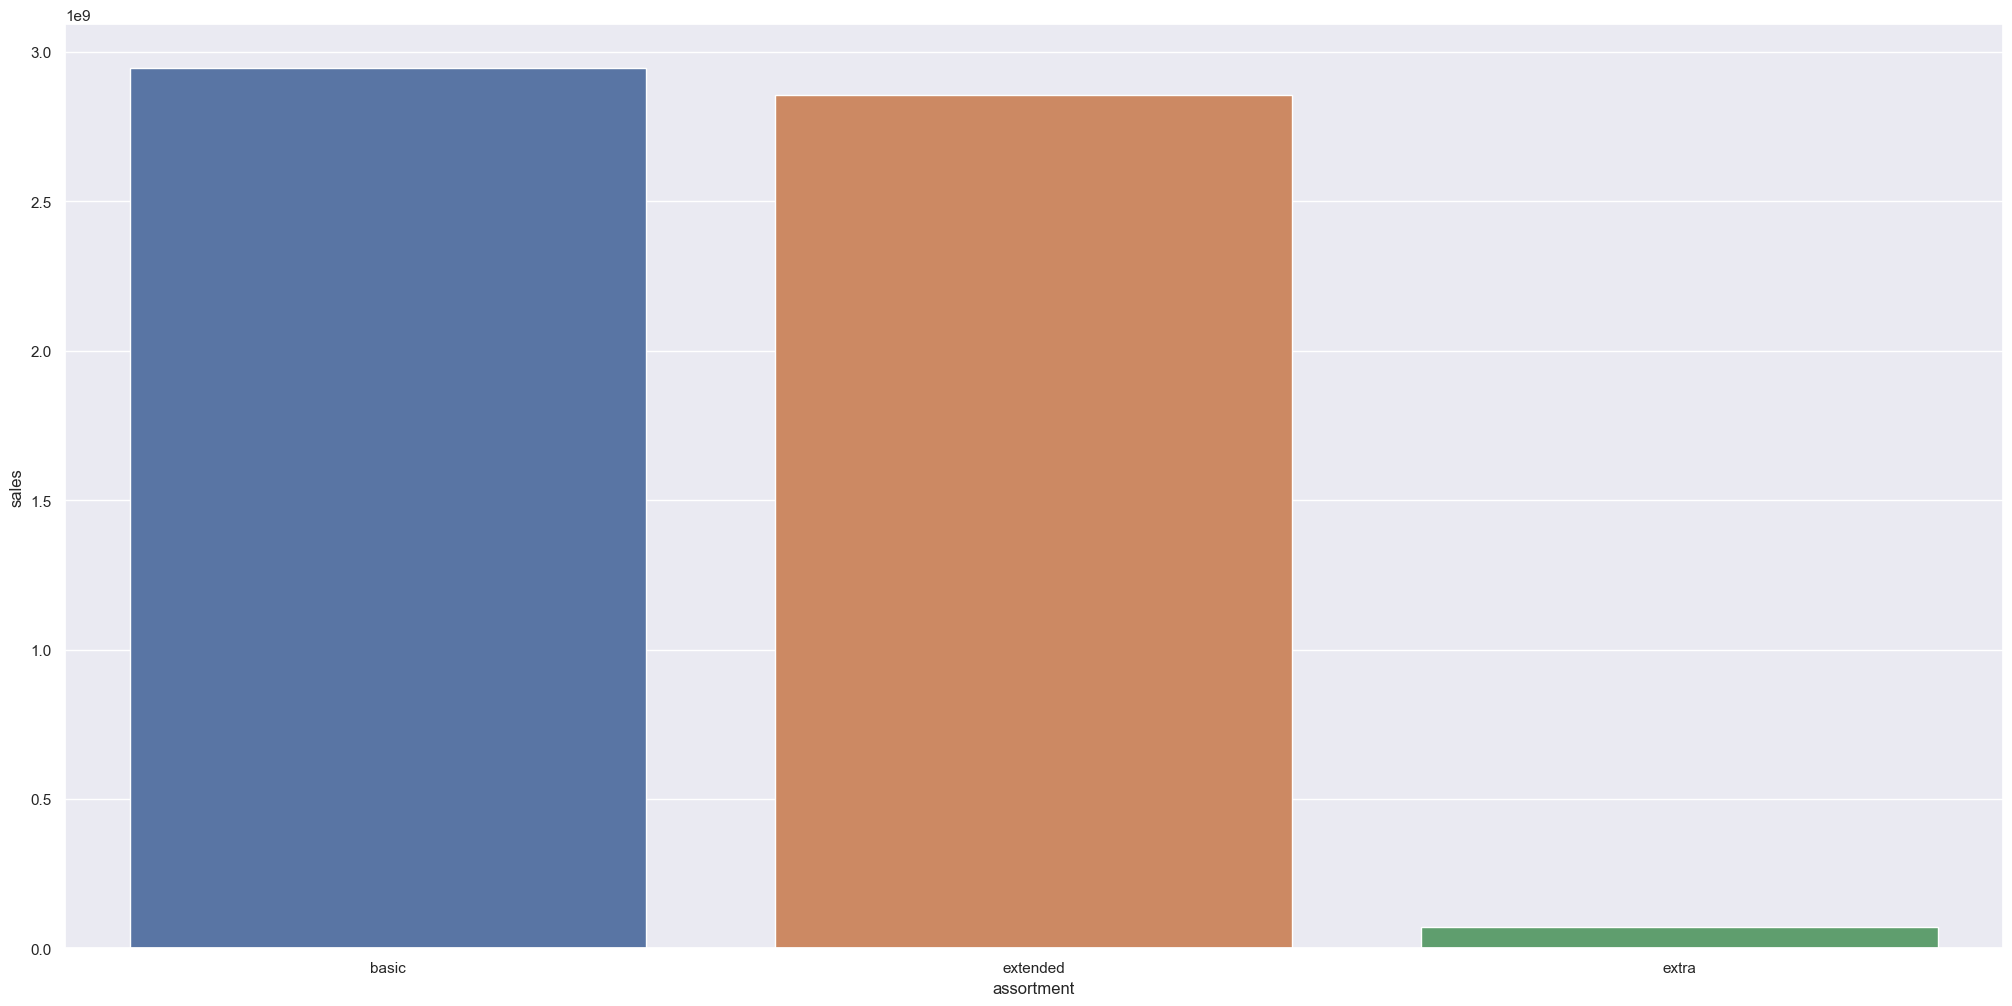

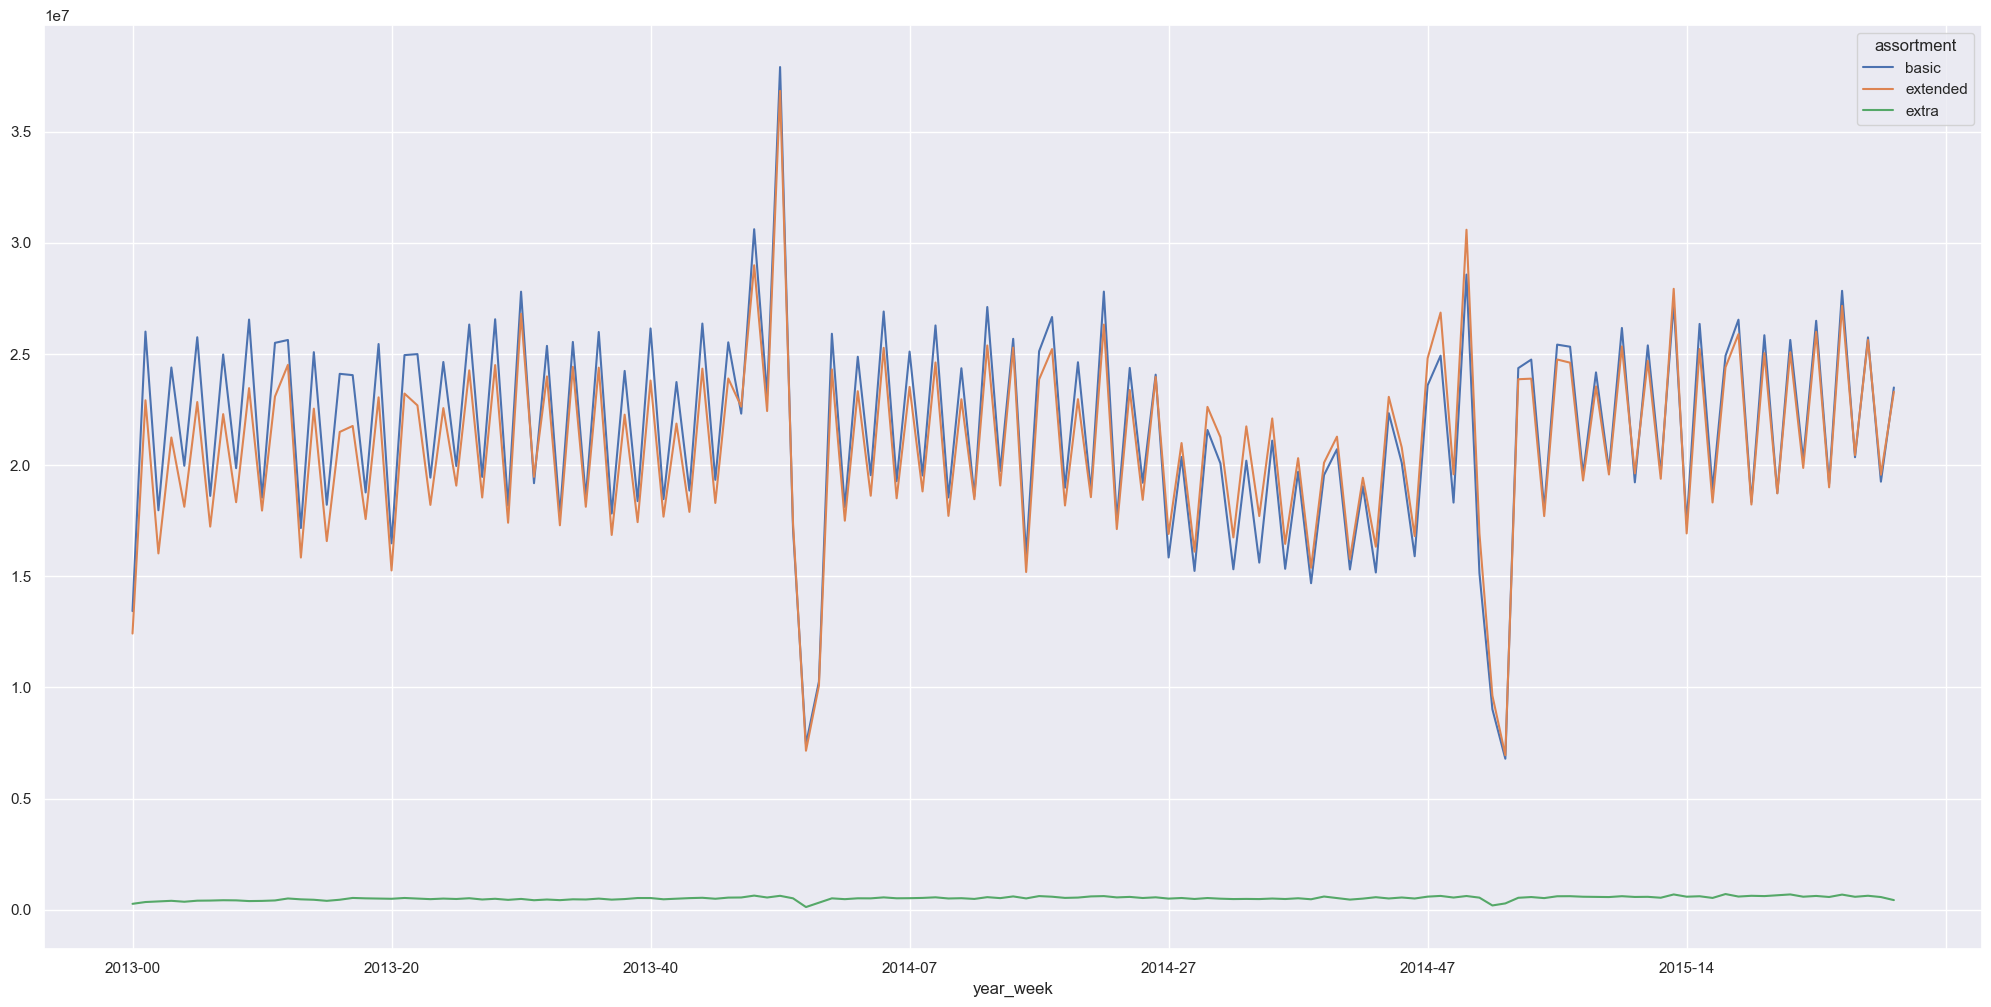

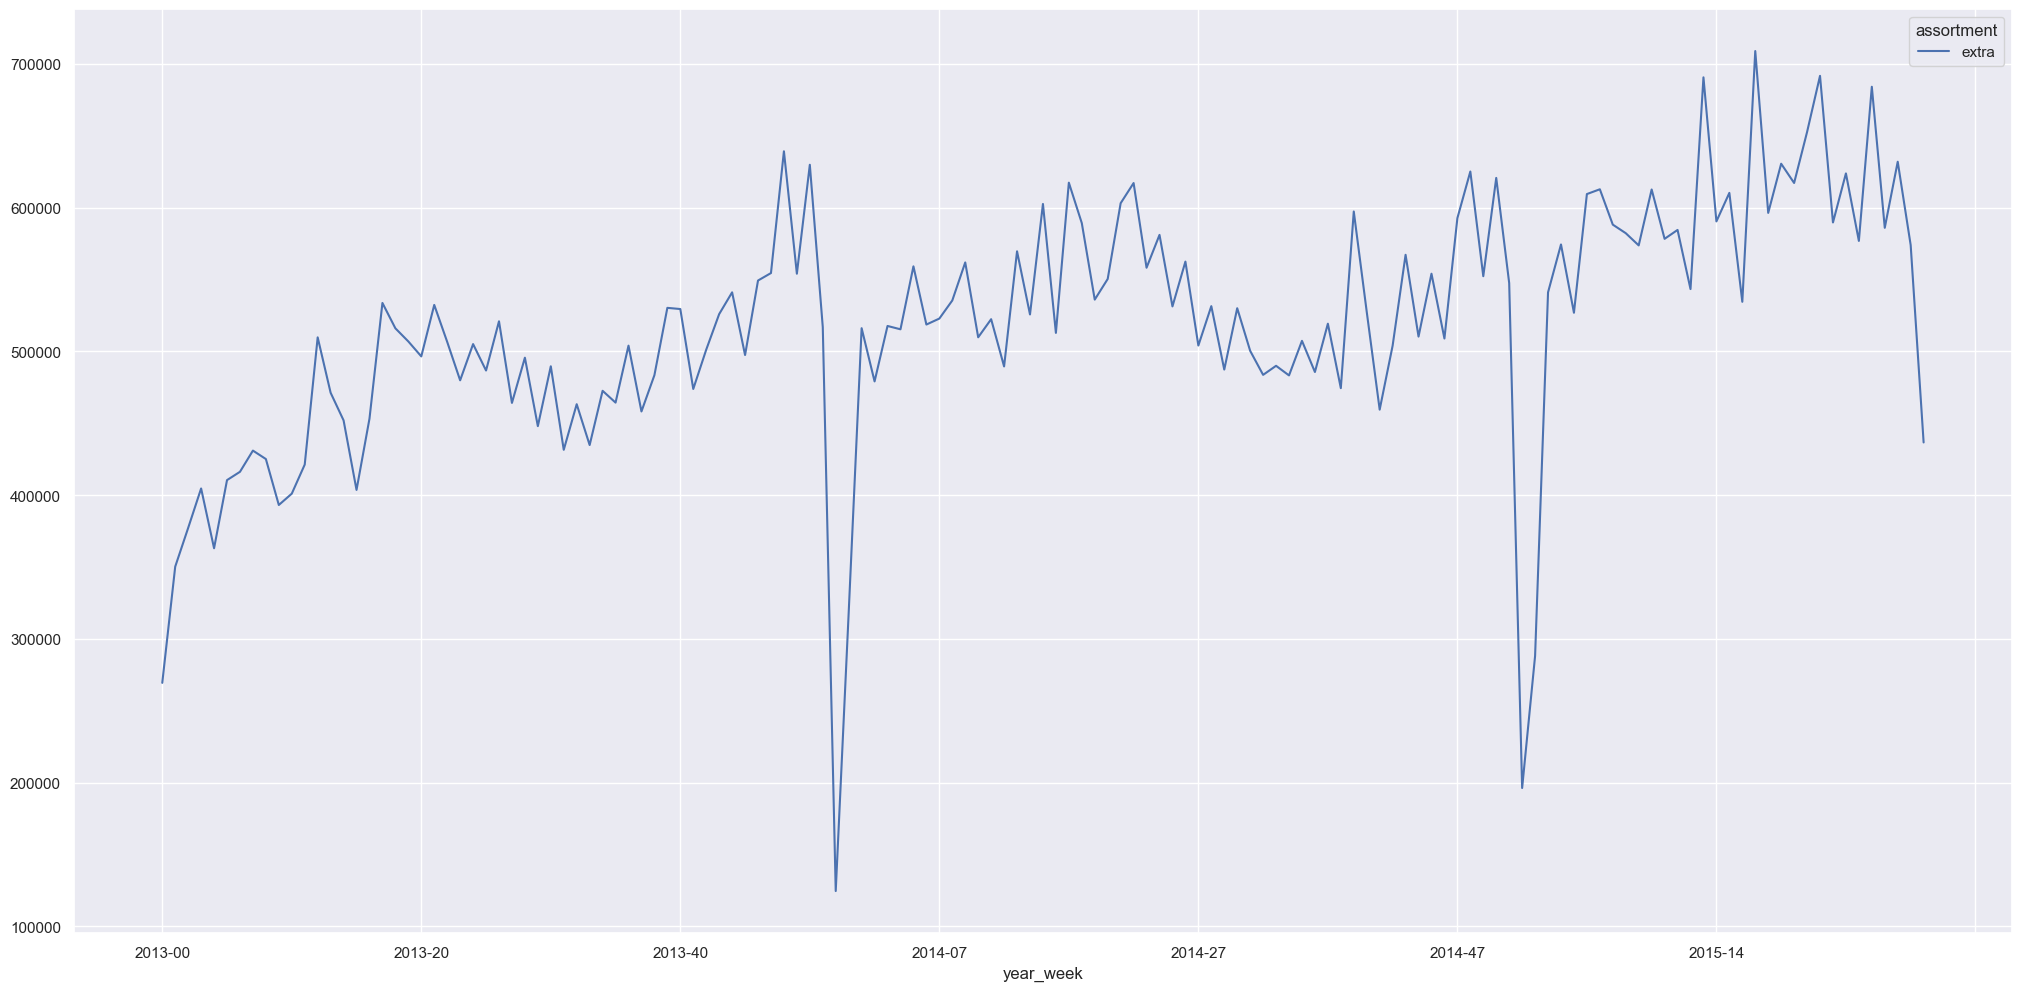

In [35]:
aux1 = df4[["assortment","sales"]].groupby("assortment").sum().reset_index()
sns.barplot(x="assortment", y="sales", data=aux1)

aux2 = df4[["year_week", "assortment","sales"]].groupby(["year_week", "assortment"]).sum().reset_index()
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot( index="year_week", columns="assortment", values="sales" ).plot()

plt.show()

### 4.2.2 H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

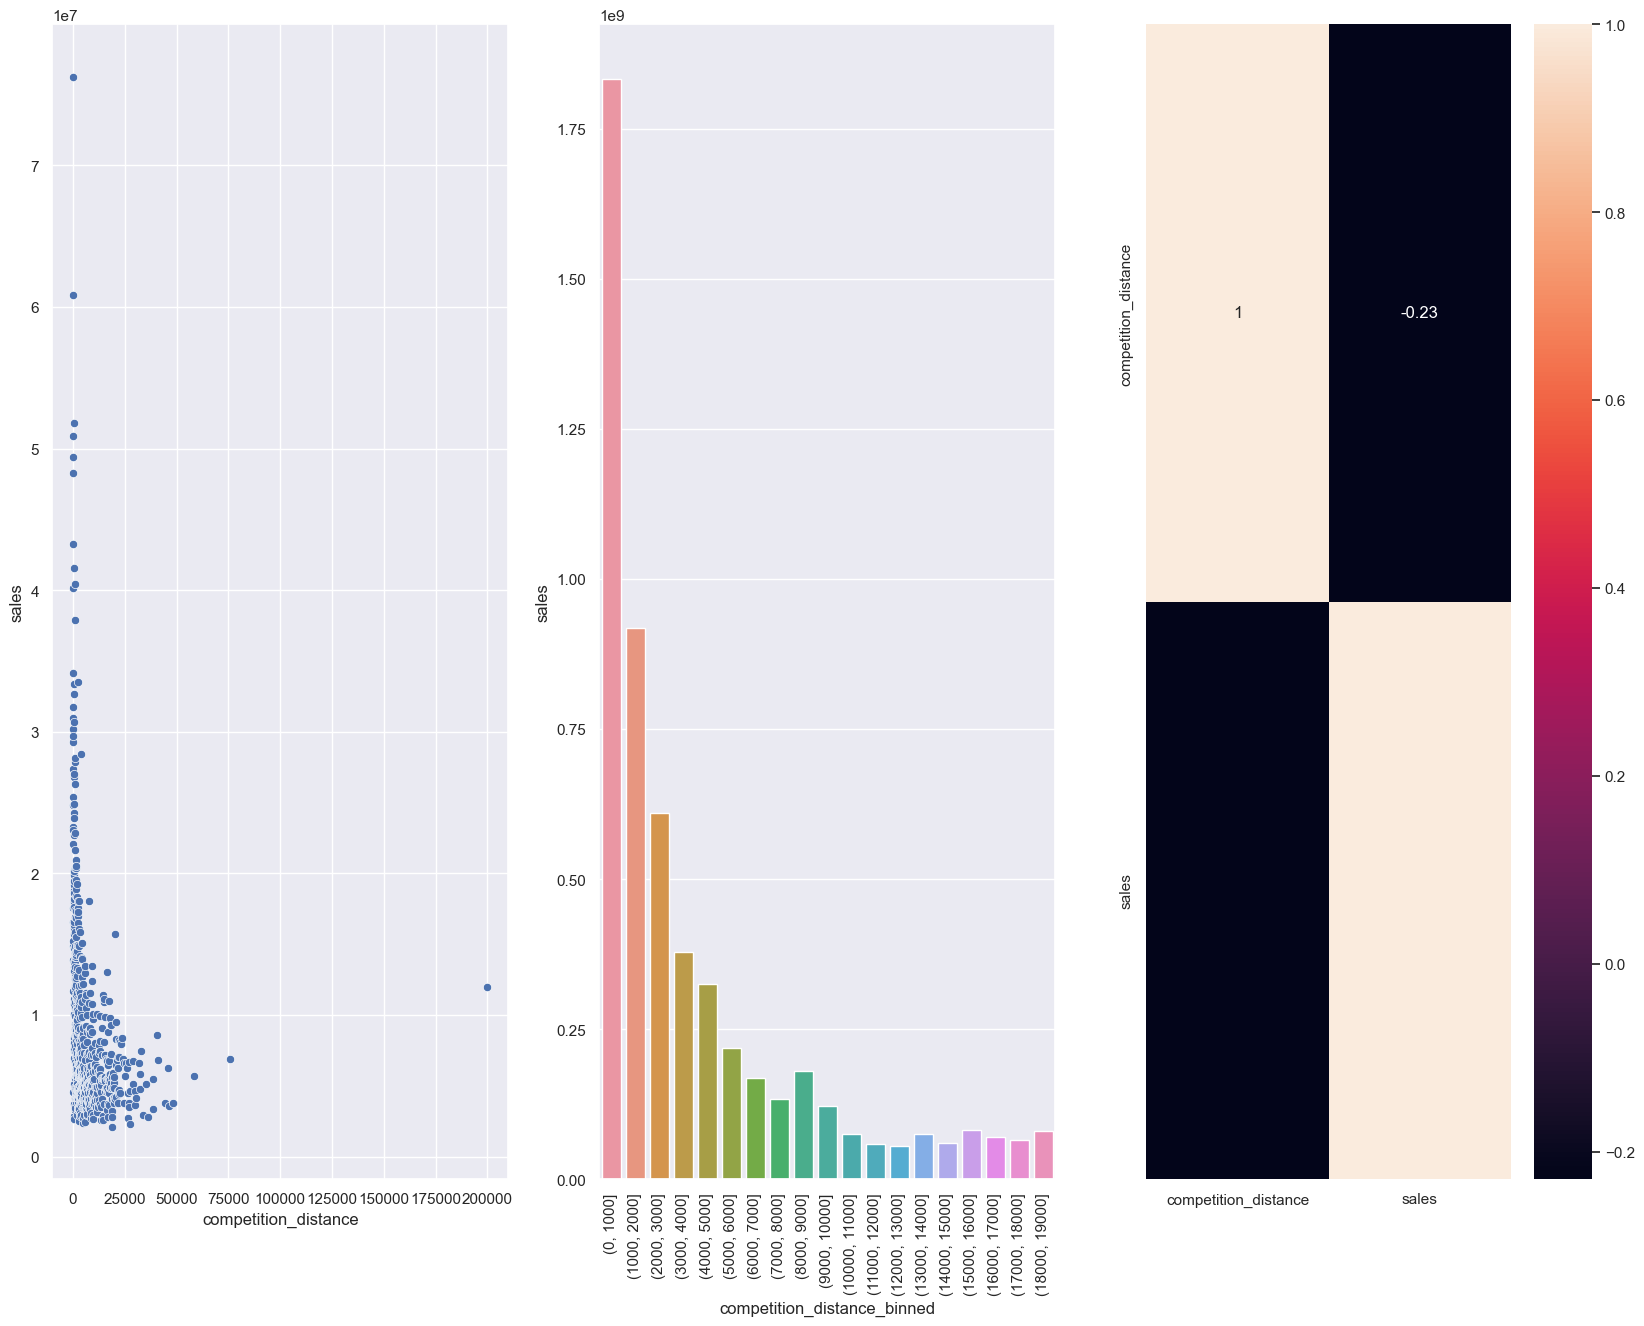

In [36]:
plt.figure(figsize=(20, 15))

aux1 = df4[["competition_distance", "sales"]].groupby( "competition_distance" ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ="competition_distance", y="sales", data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1["competition_distance_binned"] = pd.cut( aux1["competition_distance"],bins=bins )
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned" ).sum().reset_index()
sns.barplot( x="competition_distance_binned", y="sales", data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
numeric_cols = aux1.select_dtypes(include=["float64", "int64"])
corr_matrix = numeric_cols.corr(method="pearson")
sns.heatmap(corr_matrix, annot=True)

plt.show()

### 4.2.3 H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.


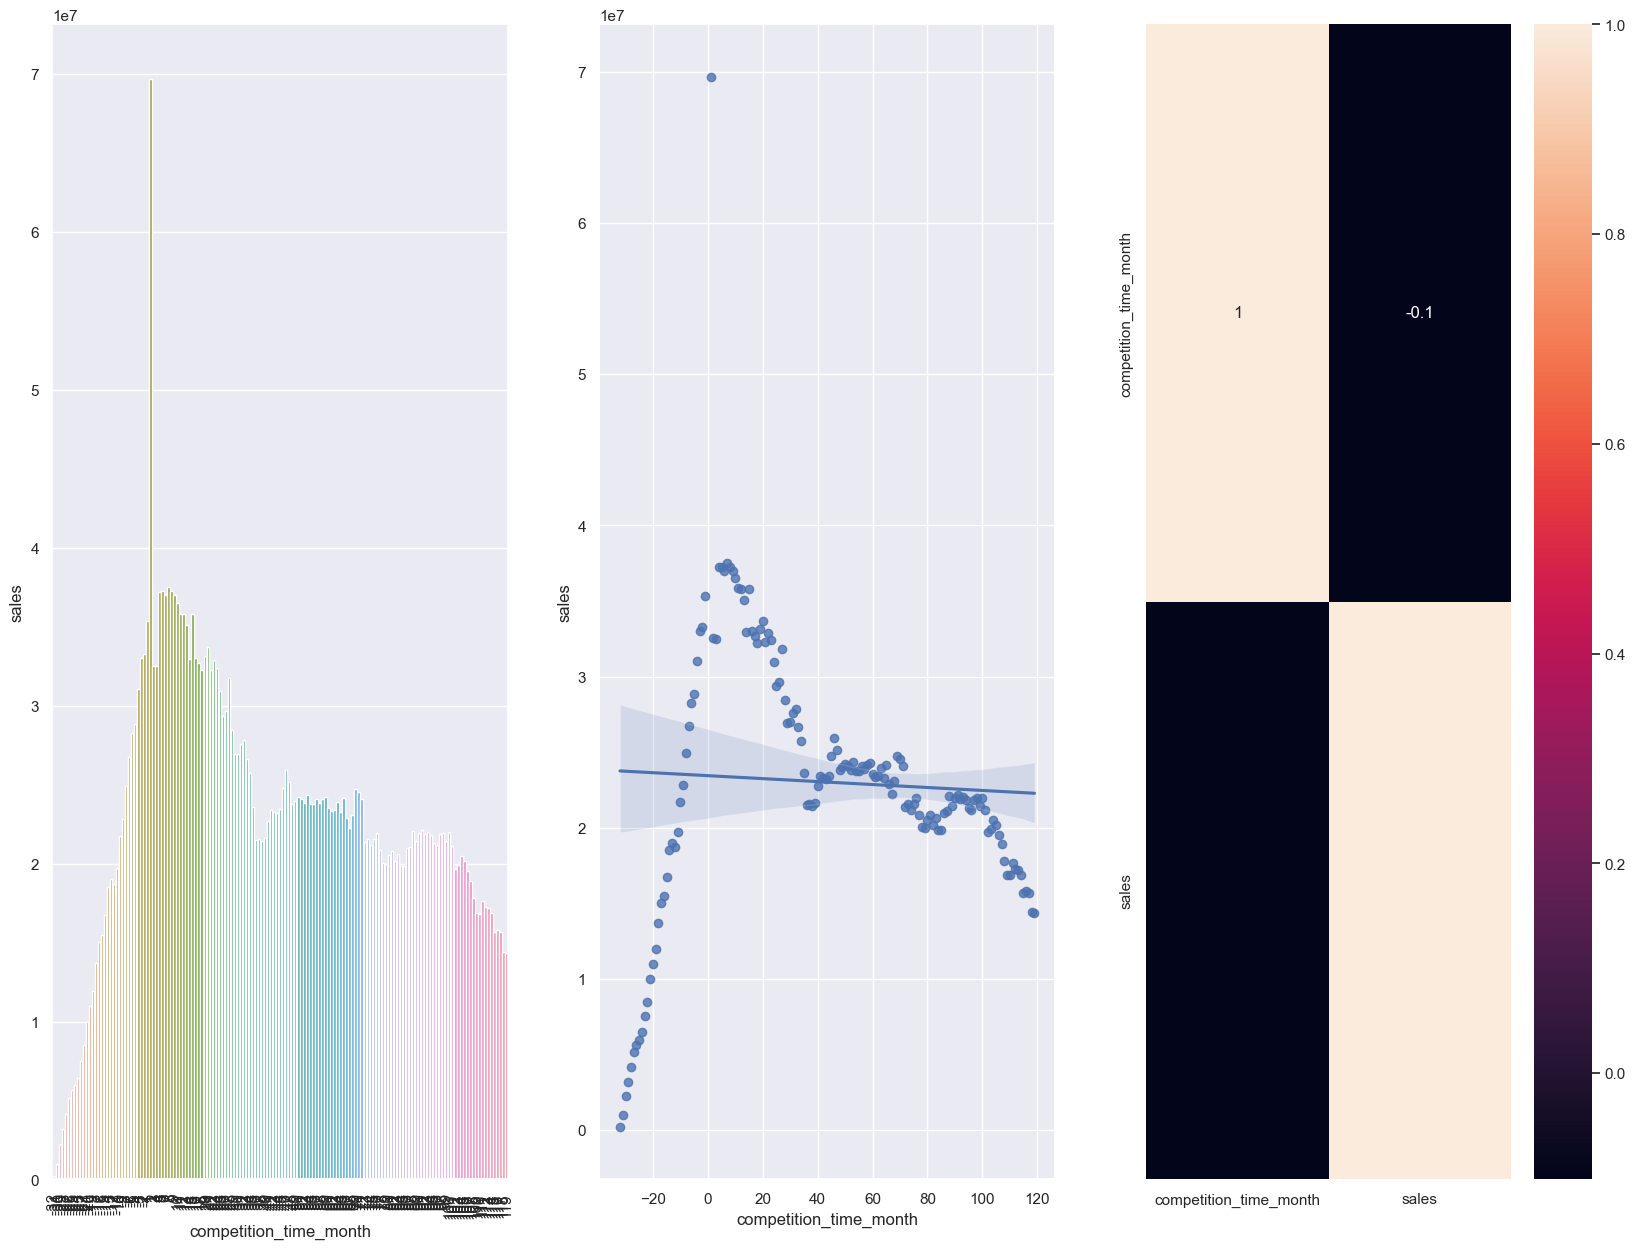

In [37]:
plt.figure(figsize=(20, 15))

plt.subplot( 1, 3, 1 )
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month" ).sum().reset_index()
aux2 = aux1[( aux1["competition_time_month"] < 120 ) & (aux1["competition_time_month"] != 0 )]
sns.barplot( x="competition_time_month", y="sales", data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x="competition_time_month", y="sales", data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method="pearson"), annot=True );

plt.show()

### 4.2.4 H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

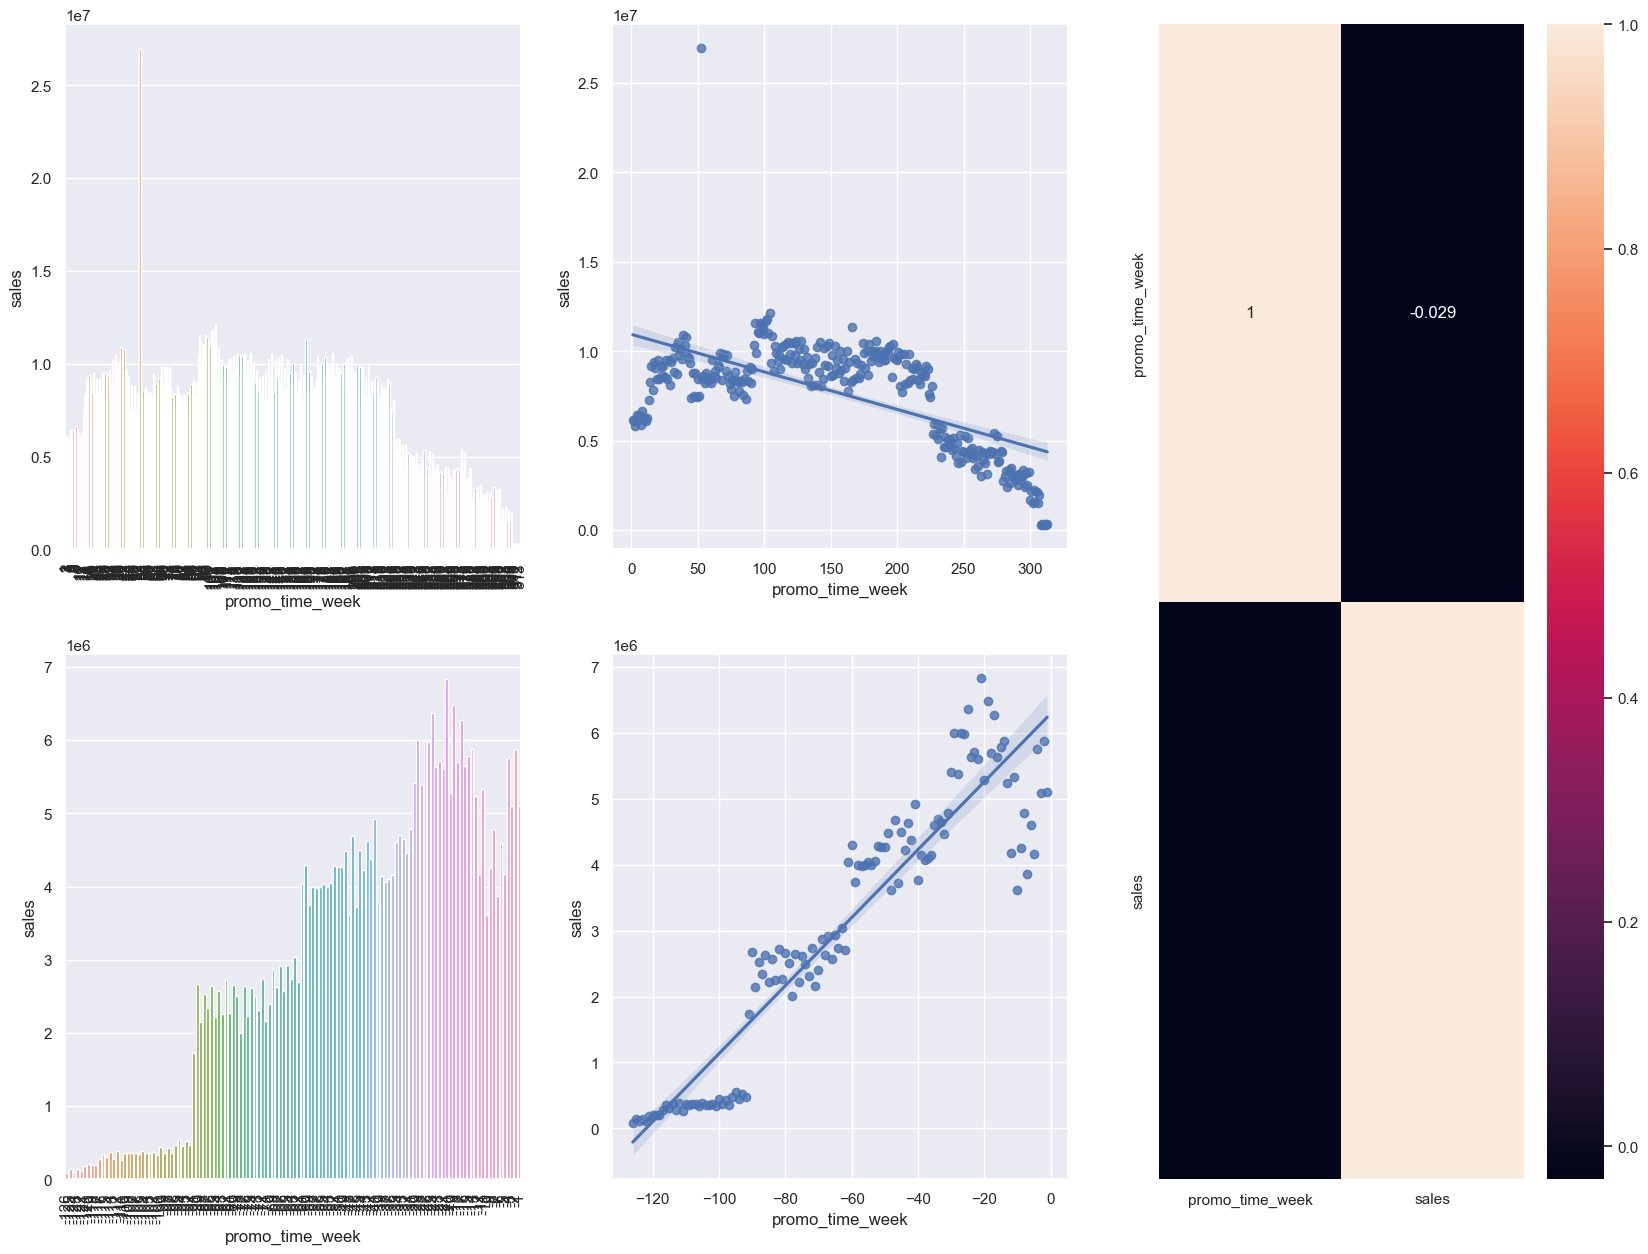

In [38]:
plt.figure(figsize=(20, 15))

aux1 = df4[["promo_time_week", "sales"]].groupby( "promo_time_week").sum().reset_index()
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )

aux2 = aux1[aux1["promo_time_week"] > 0] # promo extendido
sns.barplot( x="promo_time_week", y="sales", data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )

sns.regplot( x="promo_time_week", y="sales", data=aux2 );
plt.subplot( grid[1,0] )

aux3 = aux1[aux1["promo_time_week"] < 0] # promo regular
sns.barplot( x="promo_time_week", y="sales", data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )

sns.regplot( x="promo_time_week", y="sales", data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method="pearson" ), annot=True );

plt.show()

### 4.2.5 H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [39]:
df4[["promo", "promo2", "sales"]].groupby( ["promo", "promo2"] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<Figure size 2000x1500 with 0 Axes>

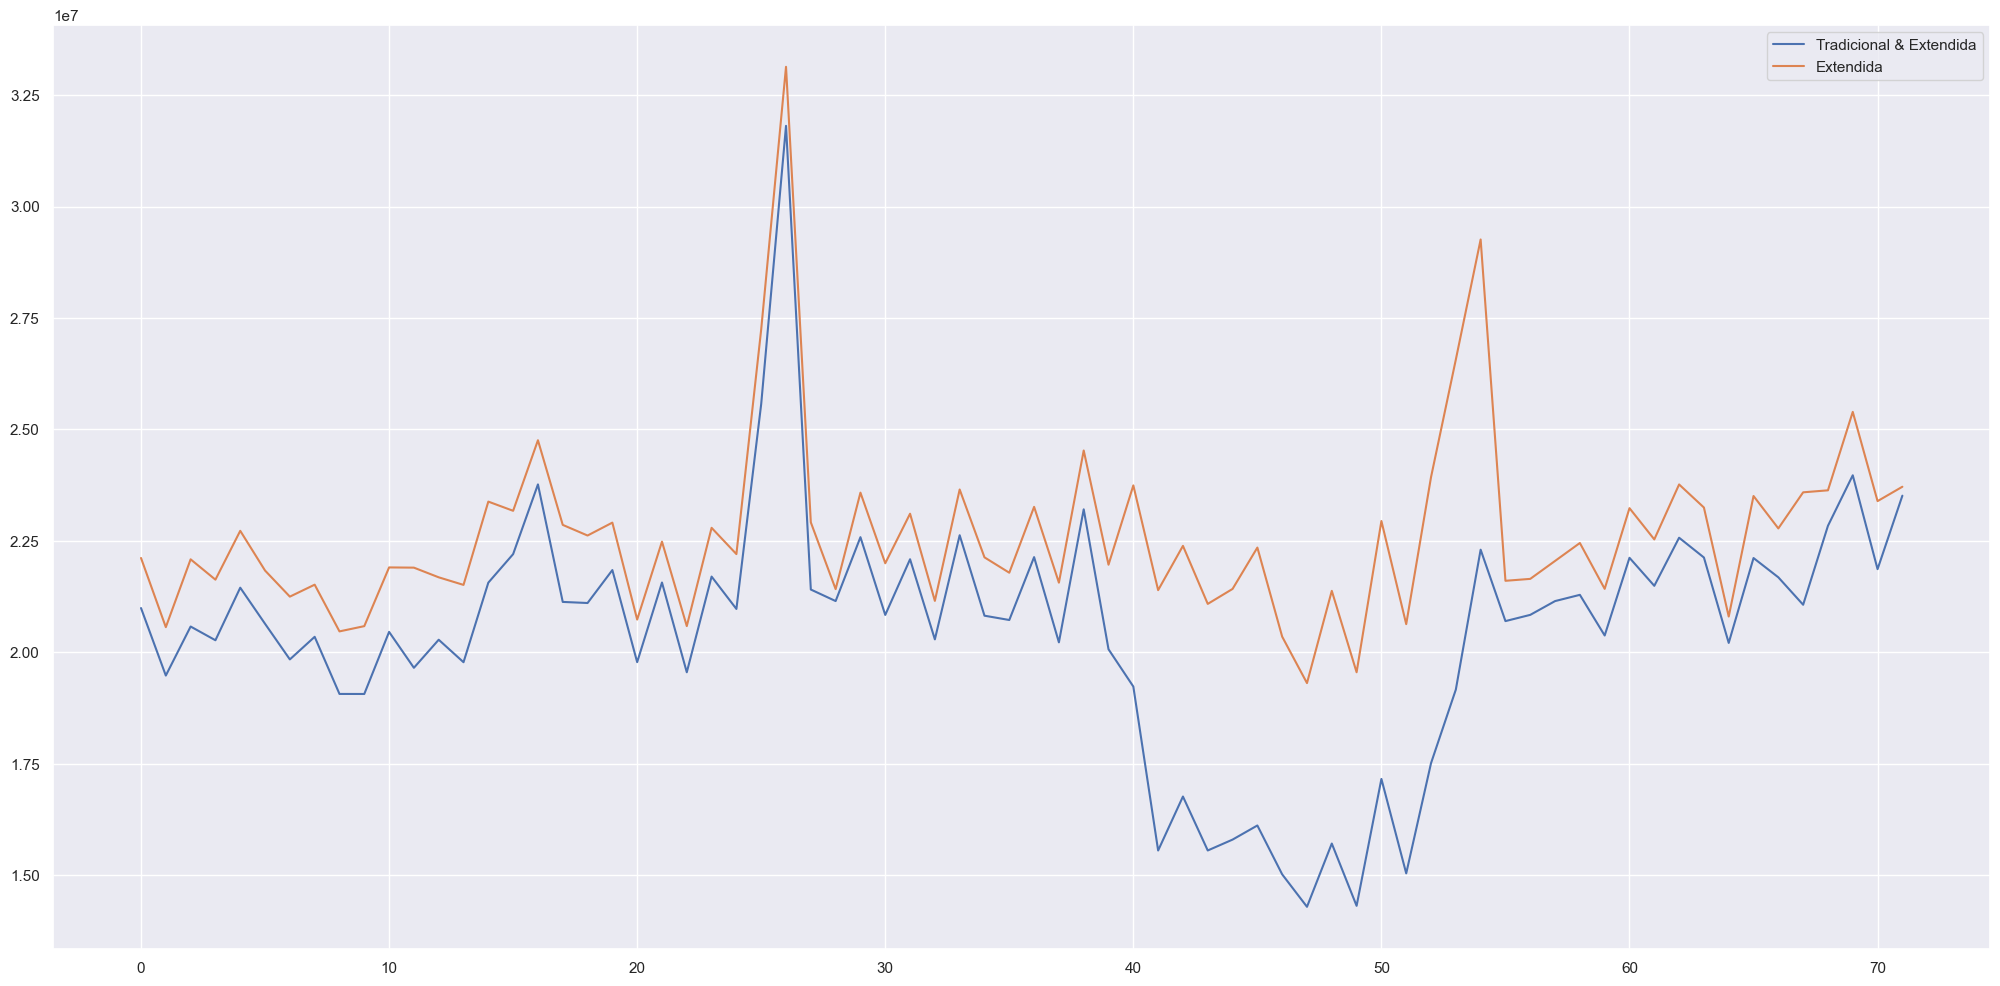

In [40]:
plt.figure(figsize=(20, 15))

aux1 = df4[( df4["promo"] == 1 ) & ( df4["promo2"] == 1 )][["year_week","sales"]].groupby( "year_week" ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4["promo"] == 1 ) & ( df4["promo2"] == 0 )][["year_week","sales"]].groupby( "year_week" ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=["Tradicional & Extendida", "Extendida"]);

plt.show()

### 4.2.6 H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

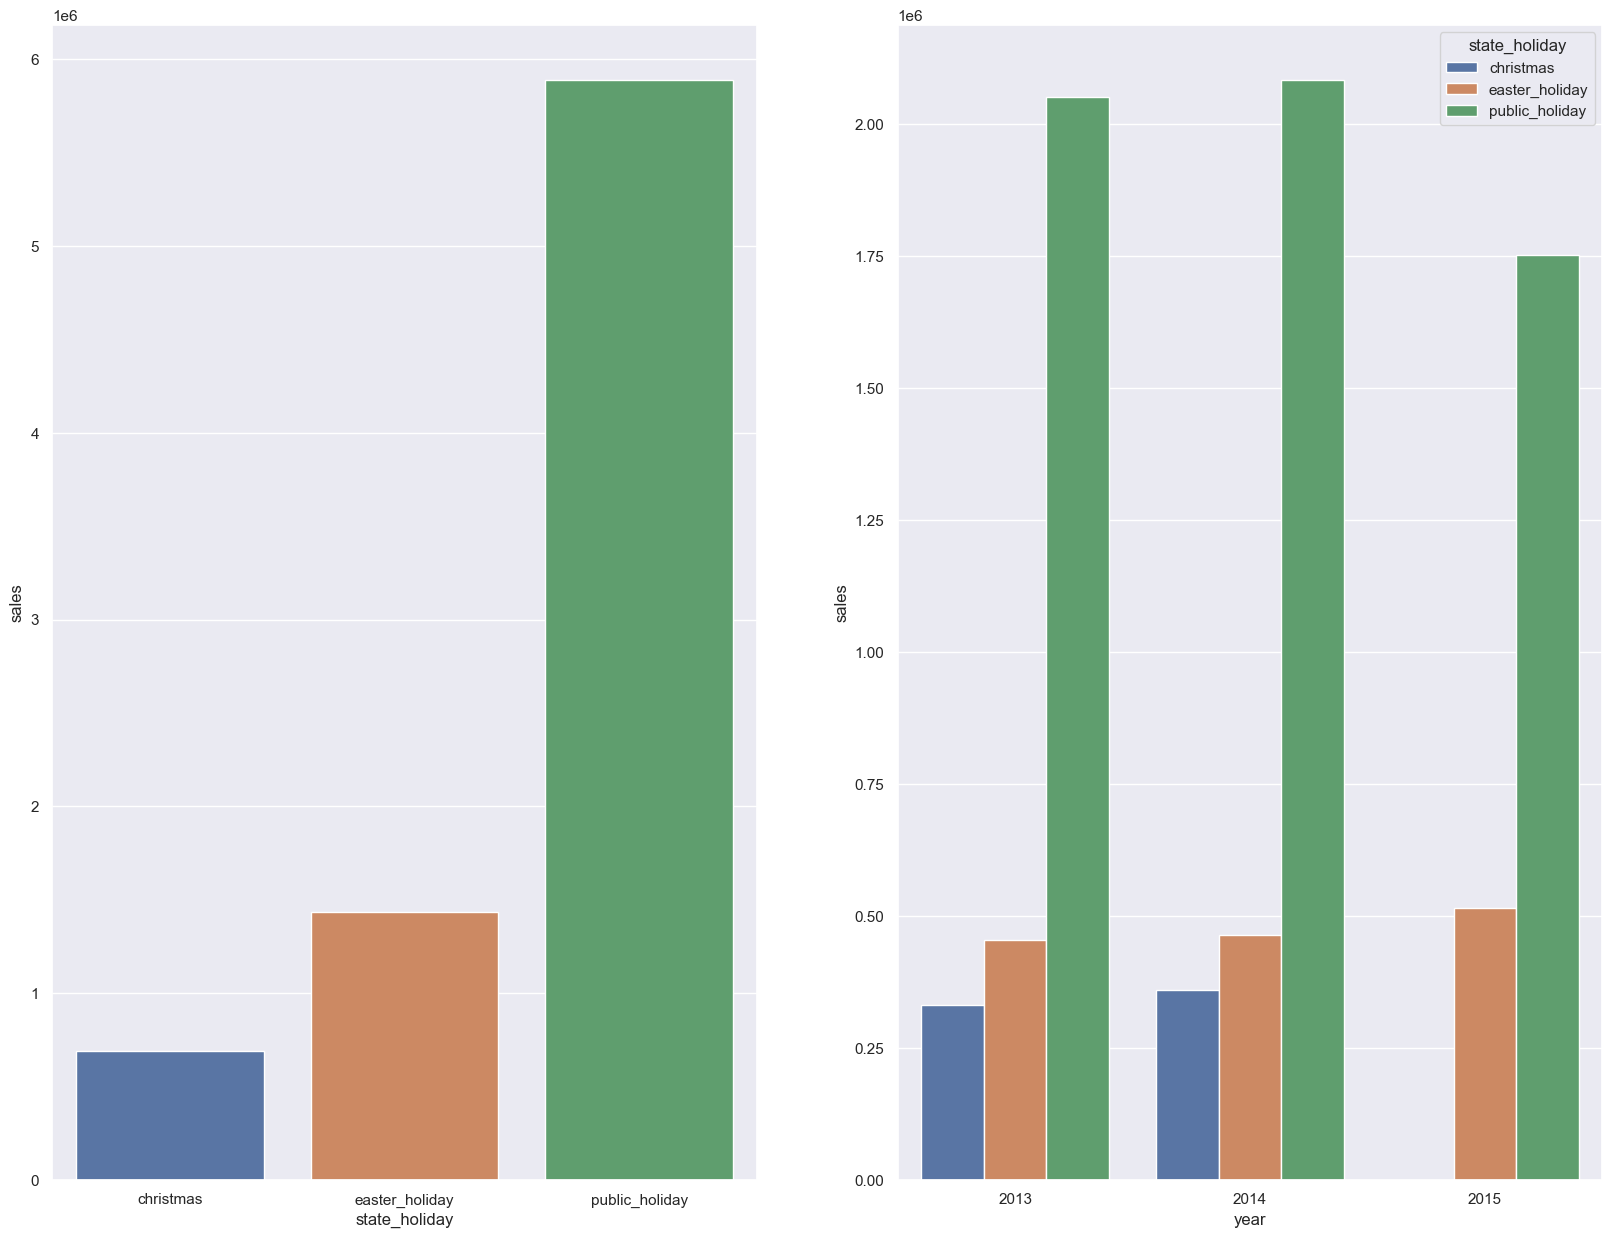

In [41]:
plt.figure(figsize=(20, 15))

aux = df4[df4["state_holiday"] != "regular_day"]
plt.subplot( 1, 2, 1 )
aux1 = aux[["state_holiday", "sales"]].groupby( "state_holiday" ).sum().reset_index()
sns.barplot( x="state_holiday", y="sales", data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[["year", "state_holiday", "sales"]].groupby( ["year","state_holiday"] ).sum().reset_index()
sns.barplot( x="year", y="sales", hue="state_holiday", data=aux2 );

plt.show()

### 4.2.7  H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

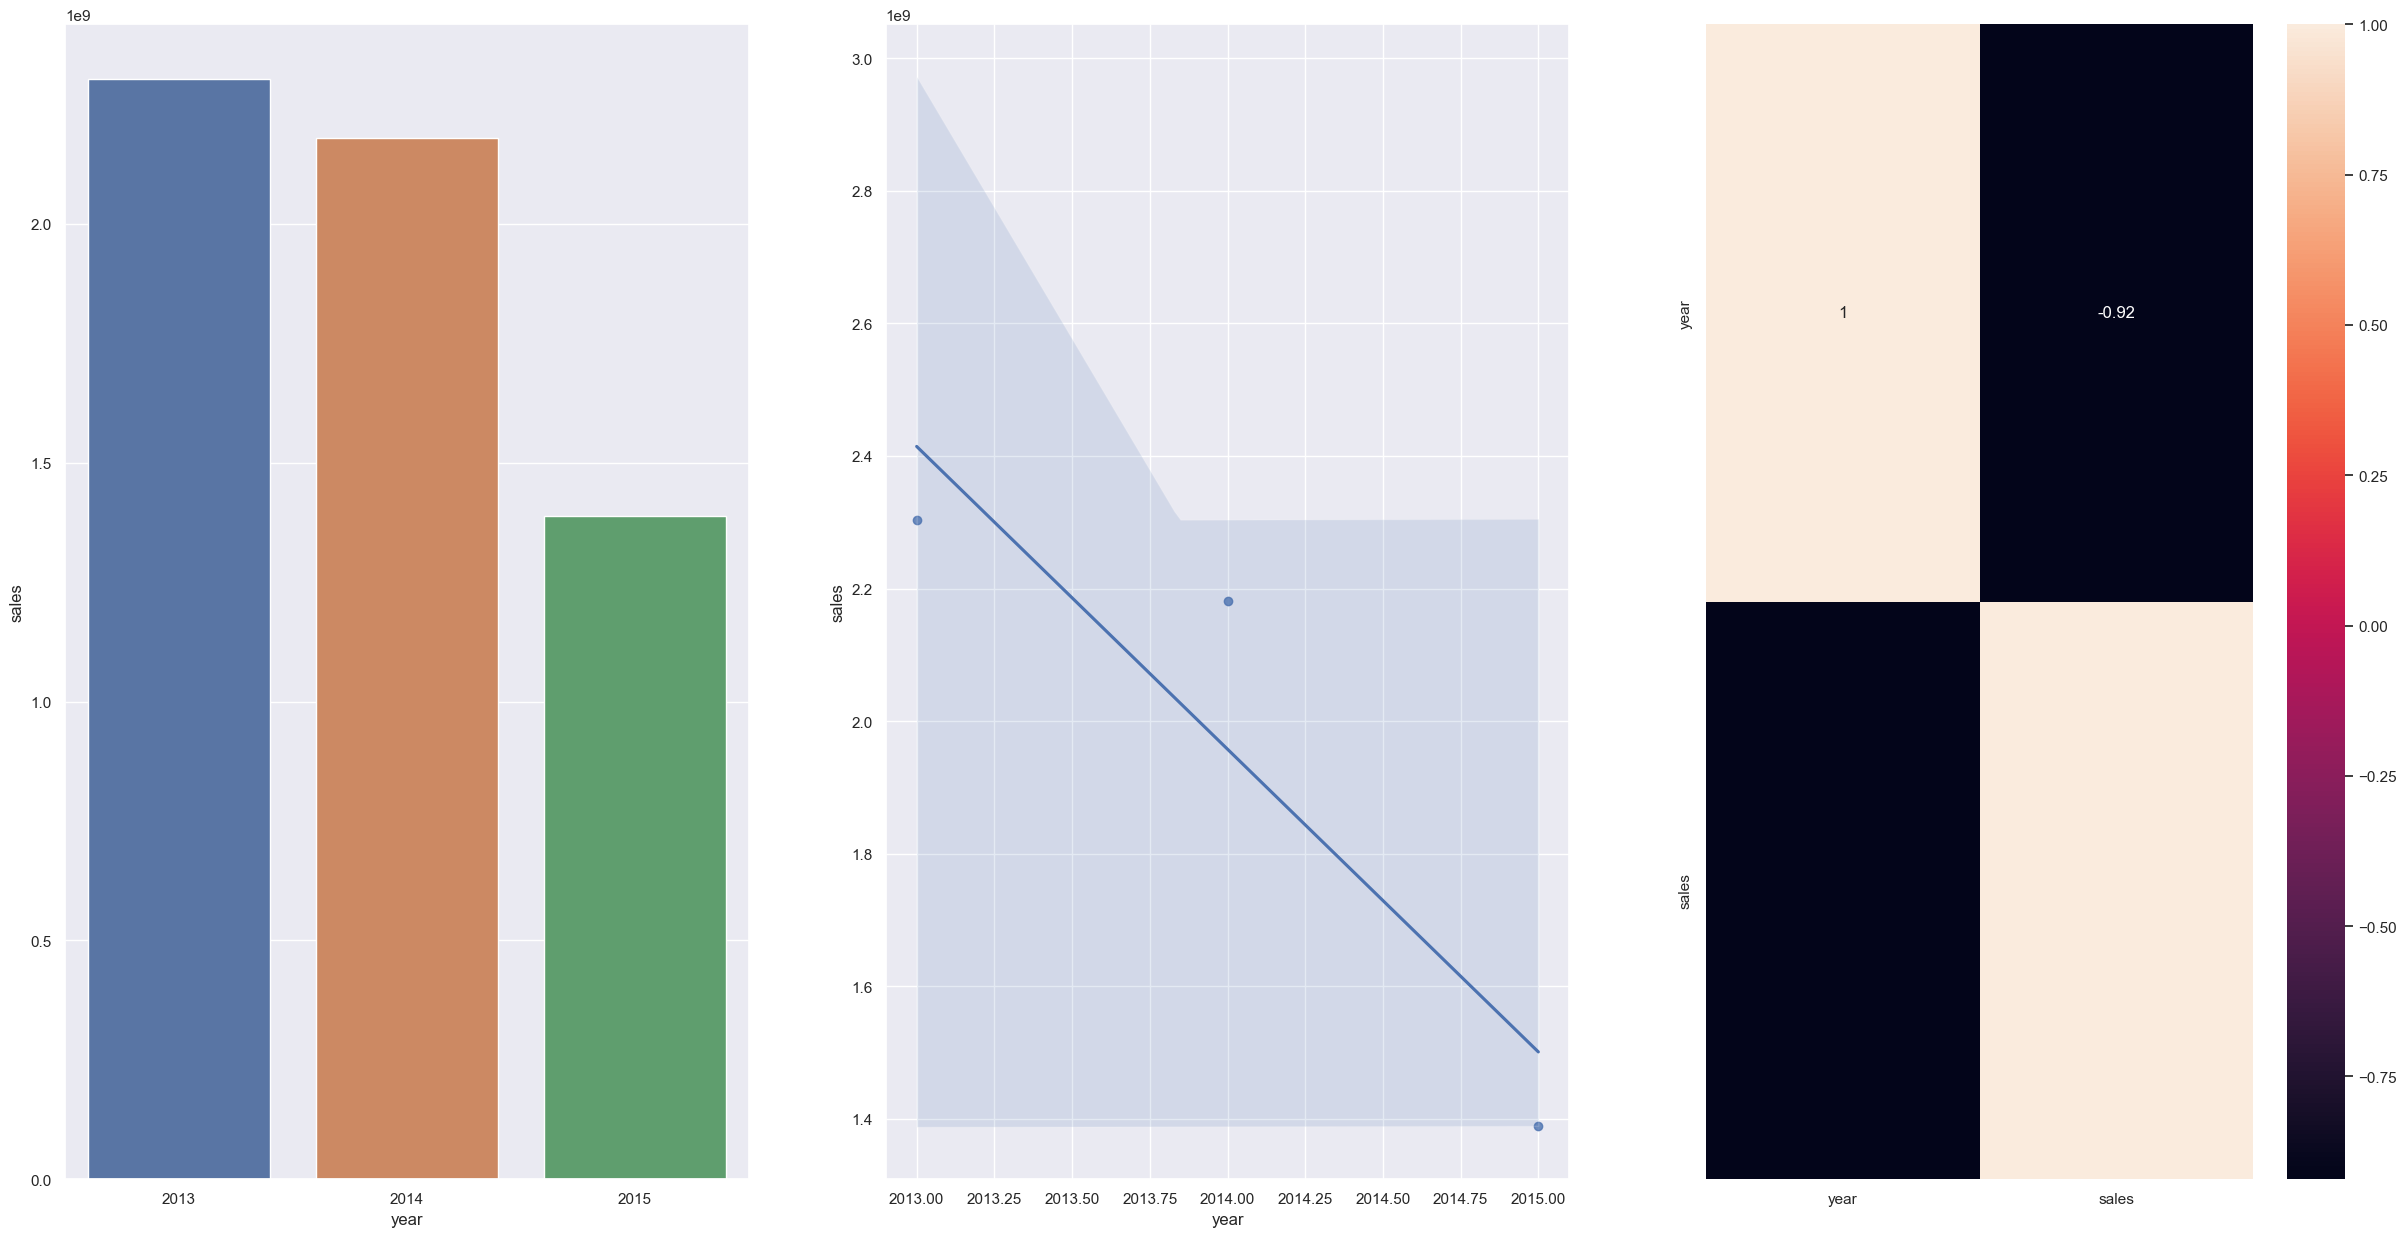

In [42]:
plt.figure(figsize=(30, 15))

aux1 = df4[["year", "sales"]].groupby( "year" ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x="year", y="sales", data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x="year", y="sales", data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method="pearson" ), annot=True );

plt.show()

### 4.2.8  H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

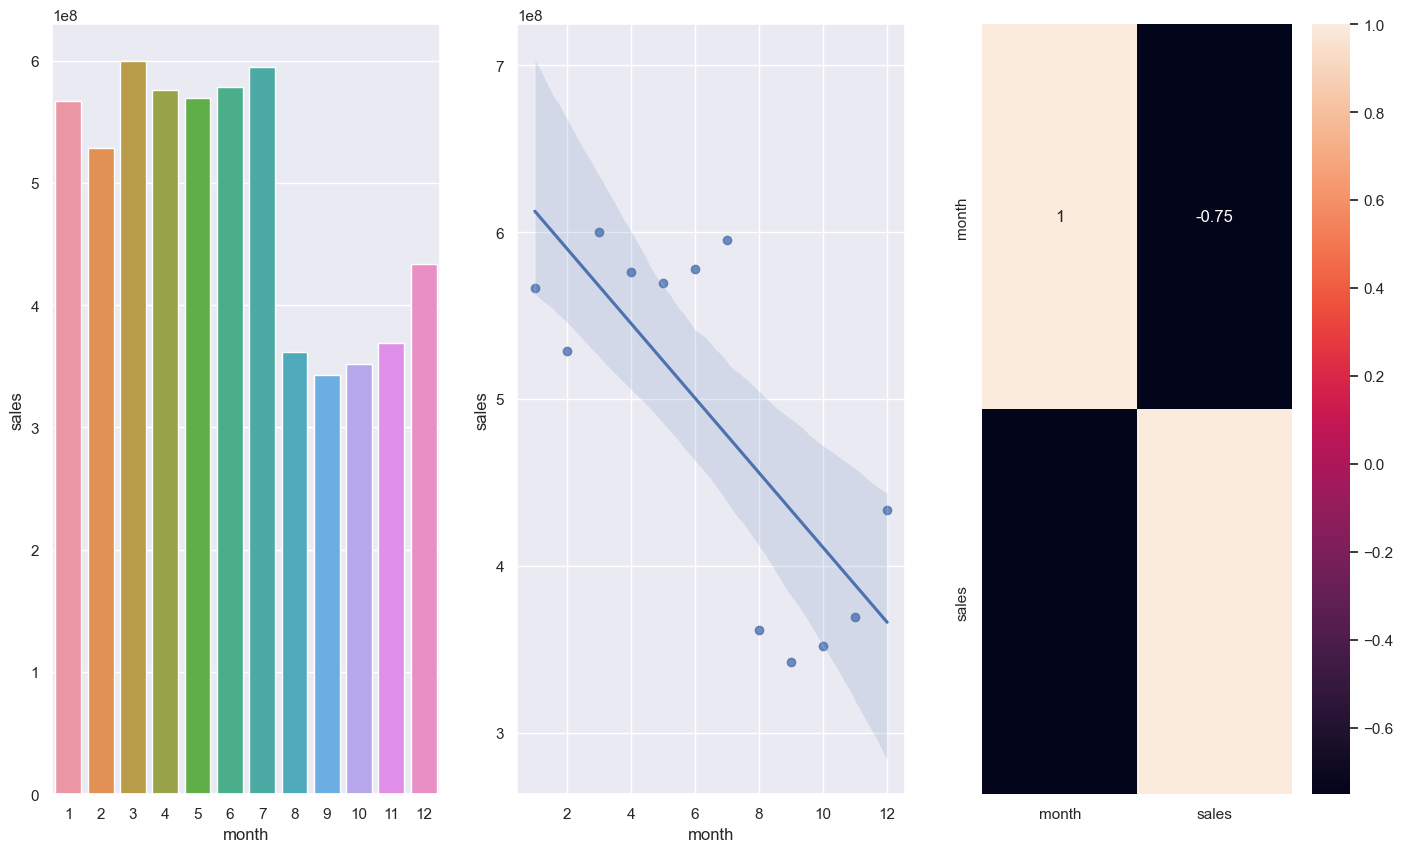

In [43]:
plt.figure(figsize=(17, 10))

aux1 = df4[["month", "sales"]].groupby( "month" ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x="month", y="sales", data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x="month", y="sales", data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method="pearson" ), annot=True );
plt.show()

### 4.2.9  H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

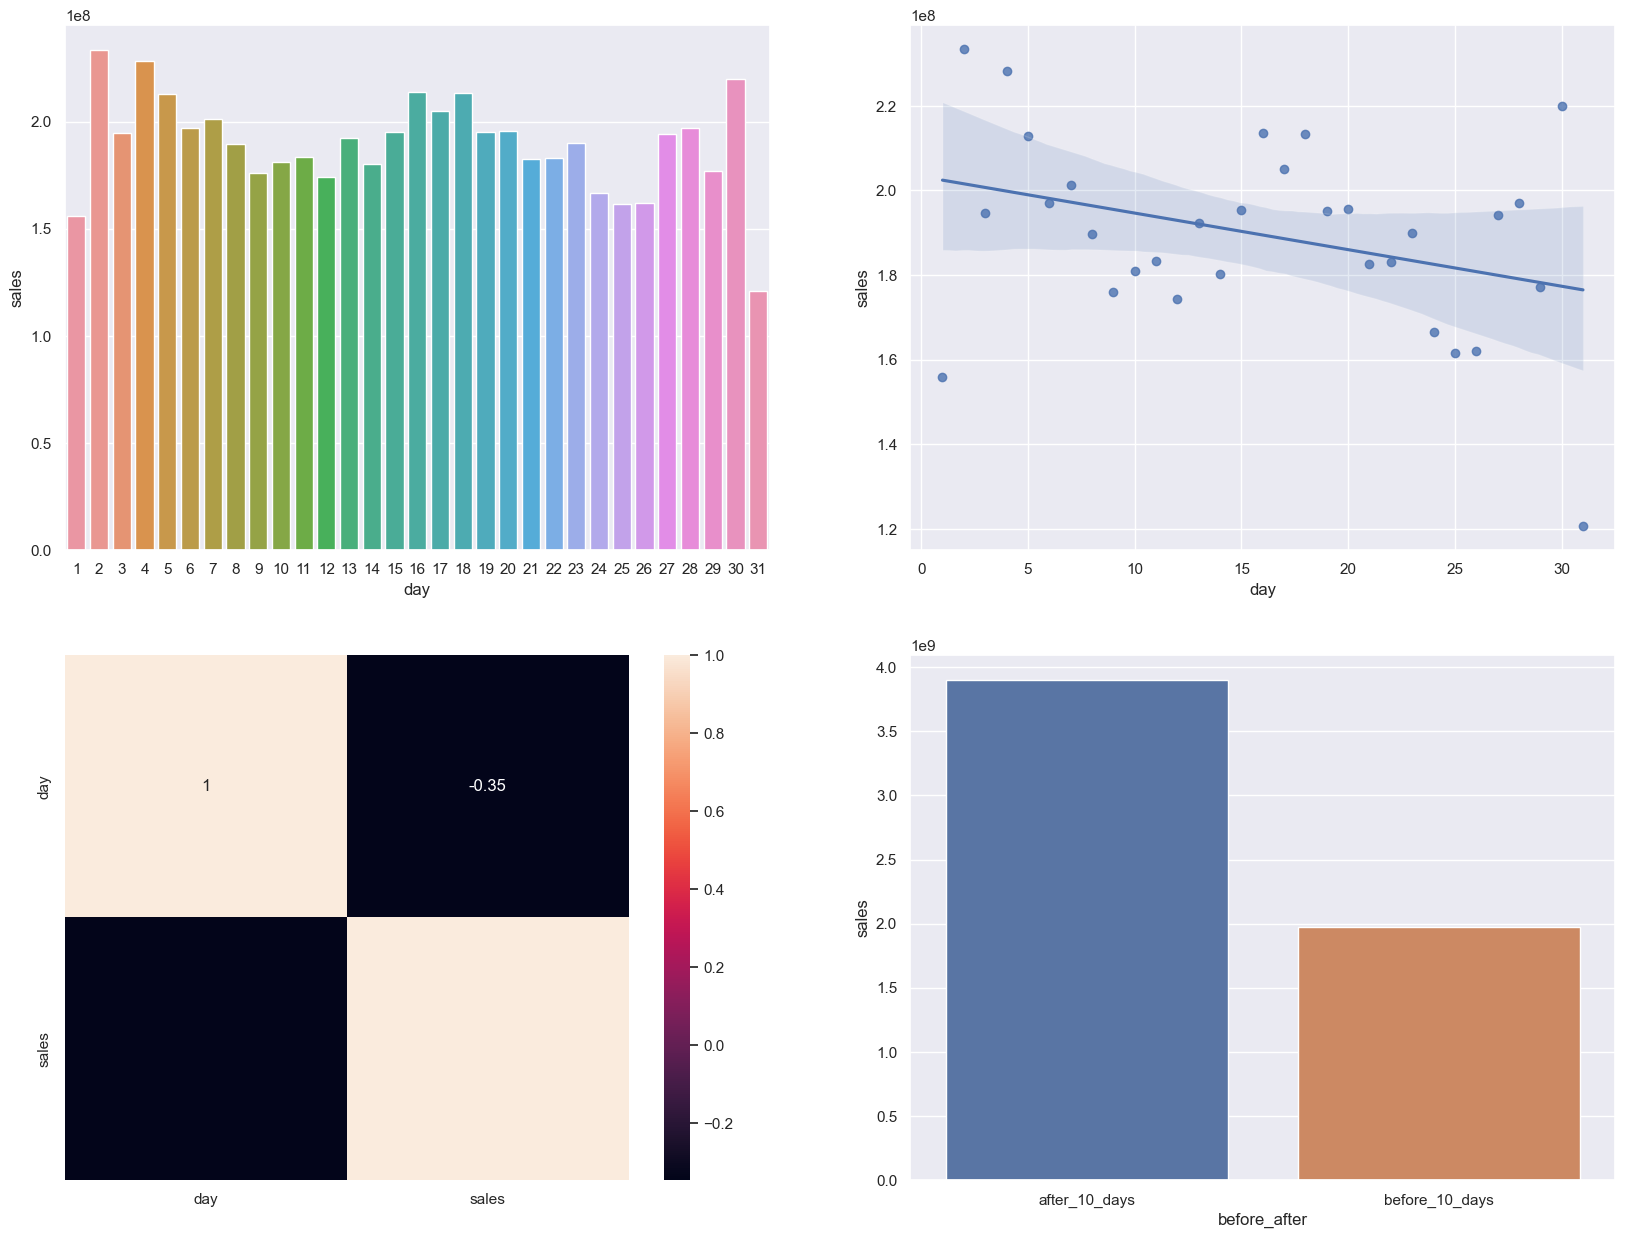

In [44]:
plt.figure(figsize=(20, 15))

aux1 = df4[["day", "sales"]].groupby( "day" ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x="day", y="sales", data=aux1 );
plt.subplot( 2, 2, 2 )
sns.regplot( x="day", y="sales", data=aux1 );
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method="pearson" ), annot=True );
aux1["before_after"] = aux1["day"].apply( lambda x: "before_10_days" if x <= 10else "after_10_days" )
aux2 =aux1[["before_after", "sales"]].groupby( "before_after" ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x="before_after", y="sales", data=aux2 );

plt.show()

### 4.2.10  H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

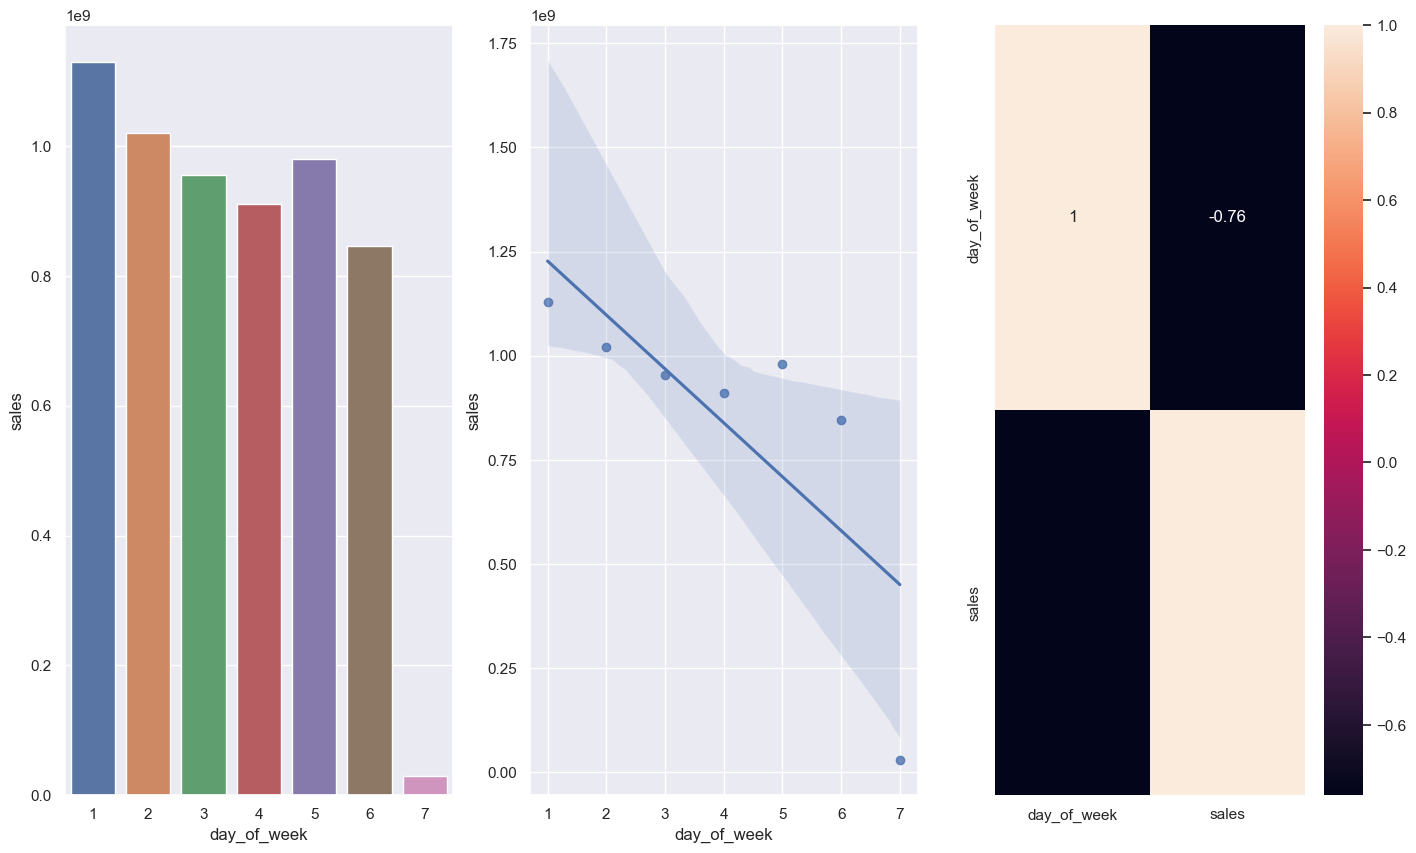

In [45]:
plt.figure(figsize=(17, 10))

aux1 = df4[["day_of_week", "sales"]].groupby( "day_of_week" ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x="day_of_week", y="sales", data=aux1 )
plt.subplot( 1, 3, 2 )
sns.regplot( x="day_of_week", y="sales", data=aux1 )
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method="pearson" ), annot=True )
# plt.tight_layout()
plt.show()

### 4.2.11  H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

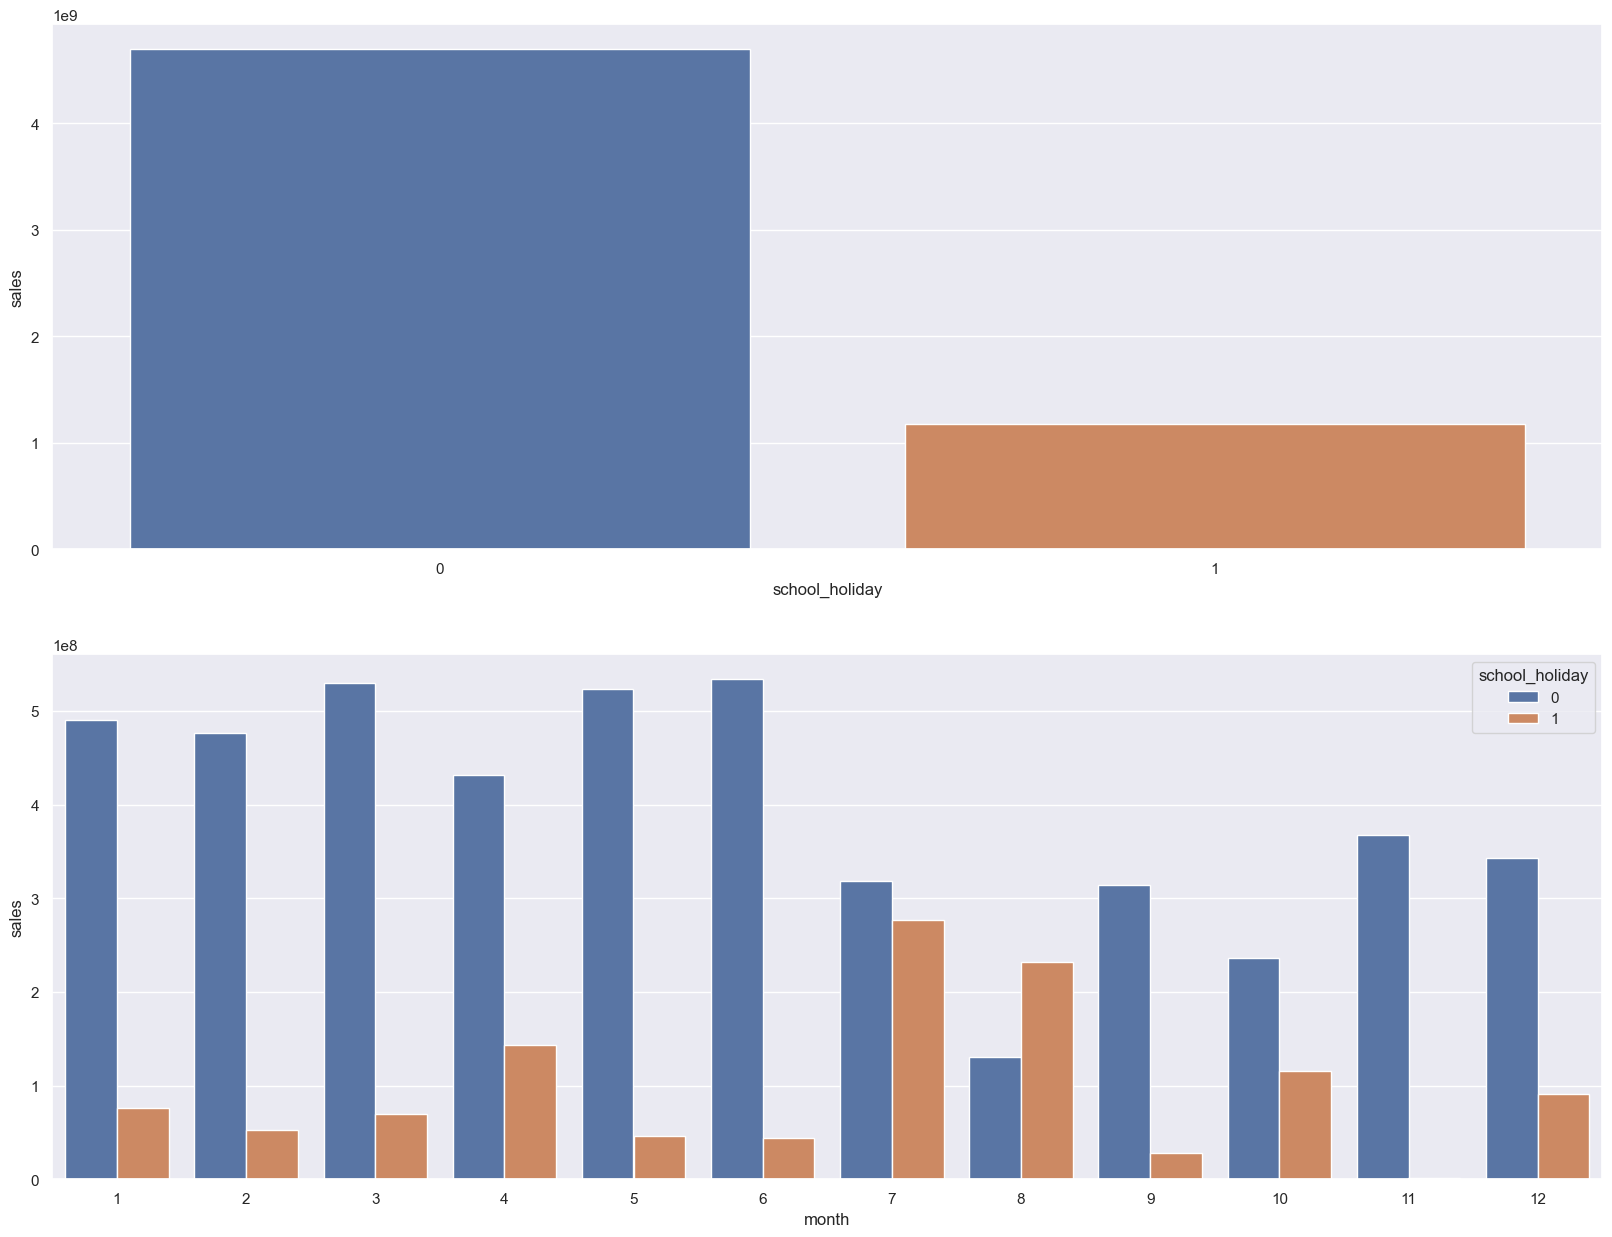

In [46]:
plt.figure(figsize=(20, 15))

aux1 = df4[["school_holiday", "sales"]].groupby( "school_holiday" ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x="school_holiday", y="sales", data=aux1 );
aux2 = df4[["month", "school_holiday", "sales"]].groupby(["month","school_holiday"] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x="month", y="sales", hue="school_holiday", data=aux2 );

plt.show()

### 4.2.12  Resumo das Hipoteses
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

In [47]:
from tabulate import tabulate

In [48]:
tab =[["Hipoteses", "Conclusao", "Relevancia"],
["H1", "Falsa", "Baixa"],
["H2", "Falsa", "Media"],
["H3", "Falsa", "Media"],
["H4", "Falsa", "Baixa"],
["H5", "-", "-"],
["H7", "Falsa", "Baixa"],
["H8", "Falsa", "Media"],
["H9", "Falsa", "Alta"],
["H10", "Falsa", "Alta"],
["H11", "Verdadeira", "Alta"],
["H12", "Verdadeira", "Alta"],
["H13", "Verdadeira", "Baixa"],]
print( tabulate( tab, headers="firstrow" ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3. Multivariate Analysis (Análise Multivariada)

### 4.3.1. Numerical Attributes

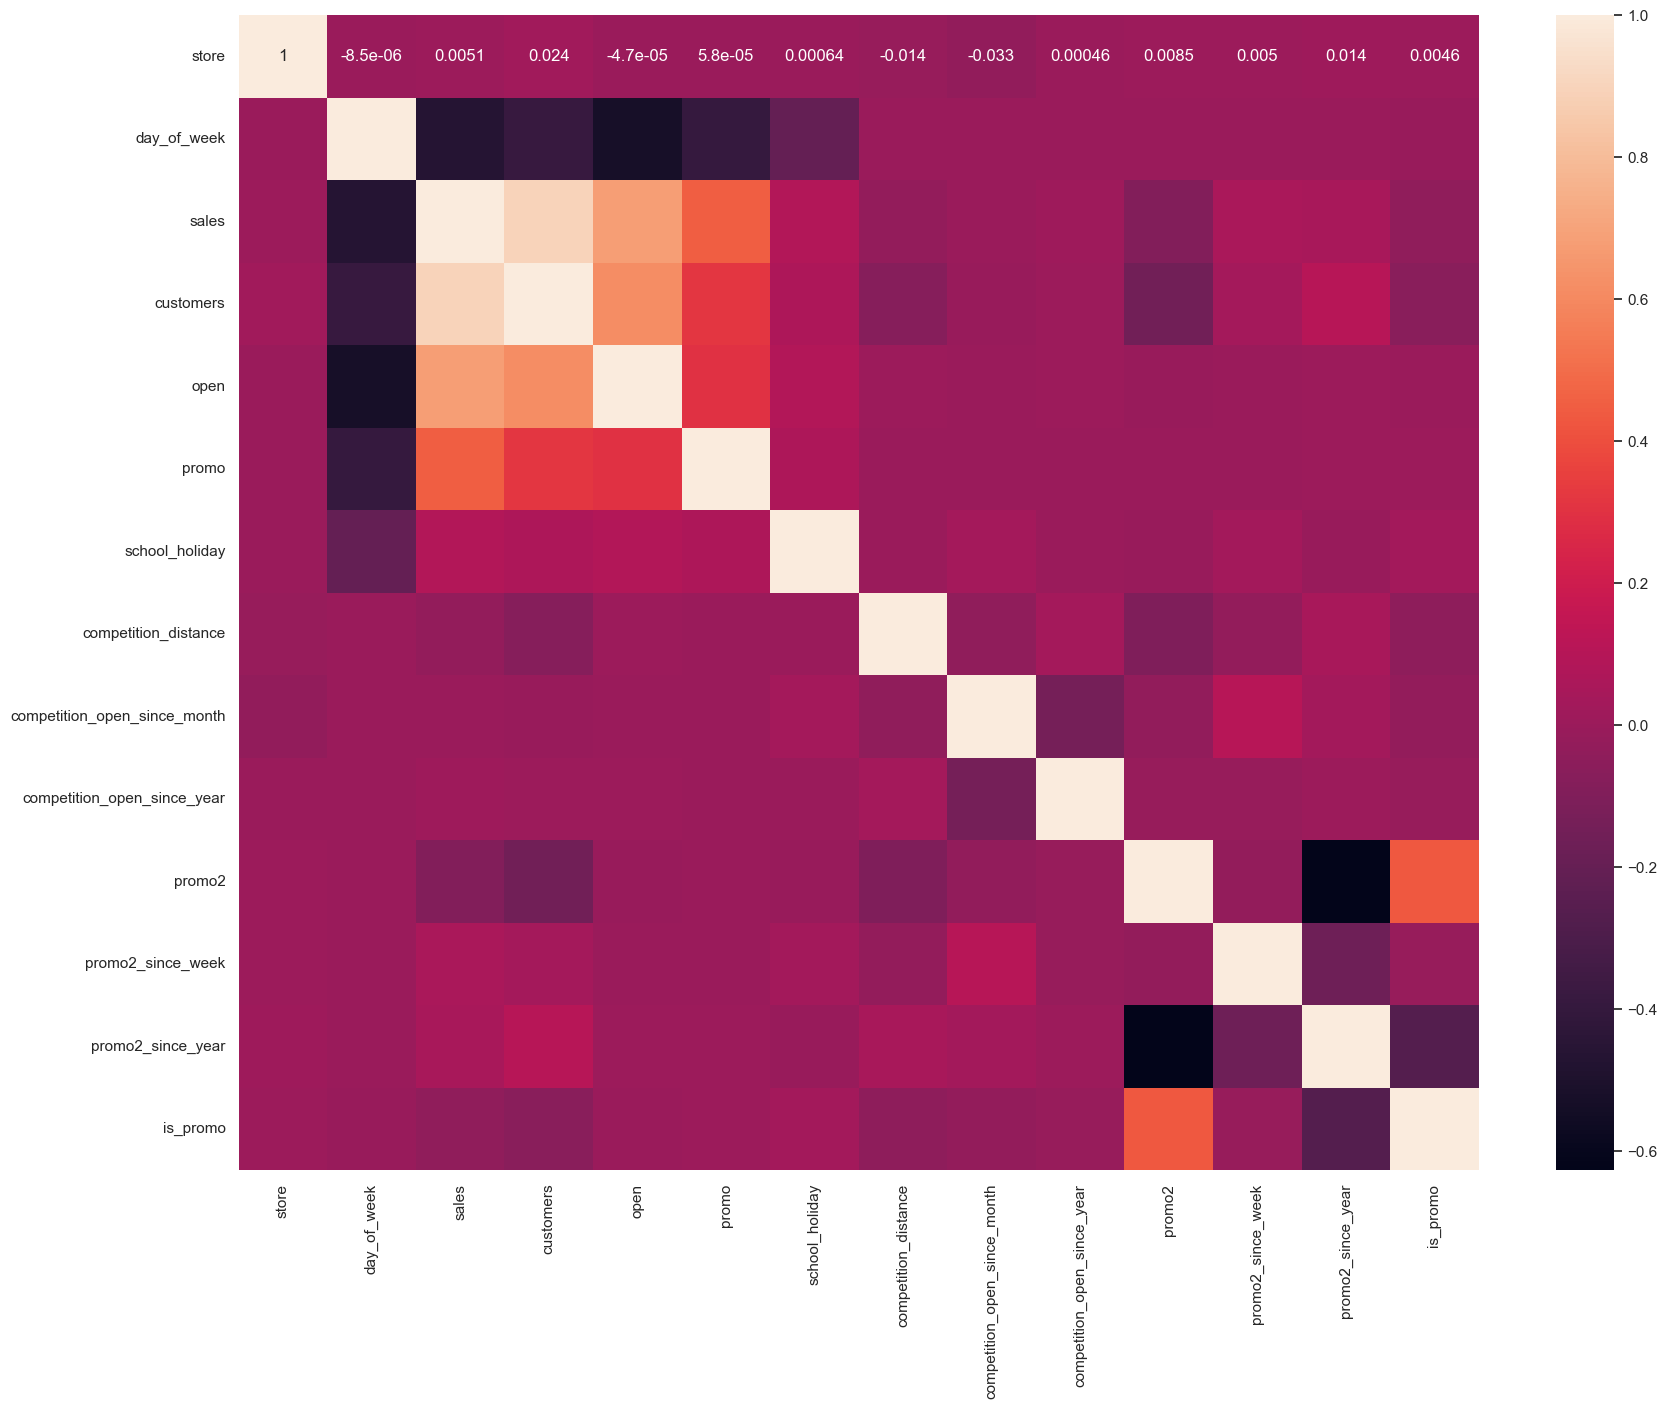

In [49]:
plt.figure(figsize=(20, 15))
correlation = num_attributes.corr (method="pearson")
sns.heatmap (correlation, annot=True)
plt.show()

### 4.3.2. Categorical Attributes

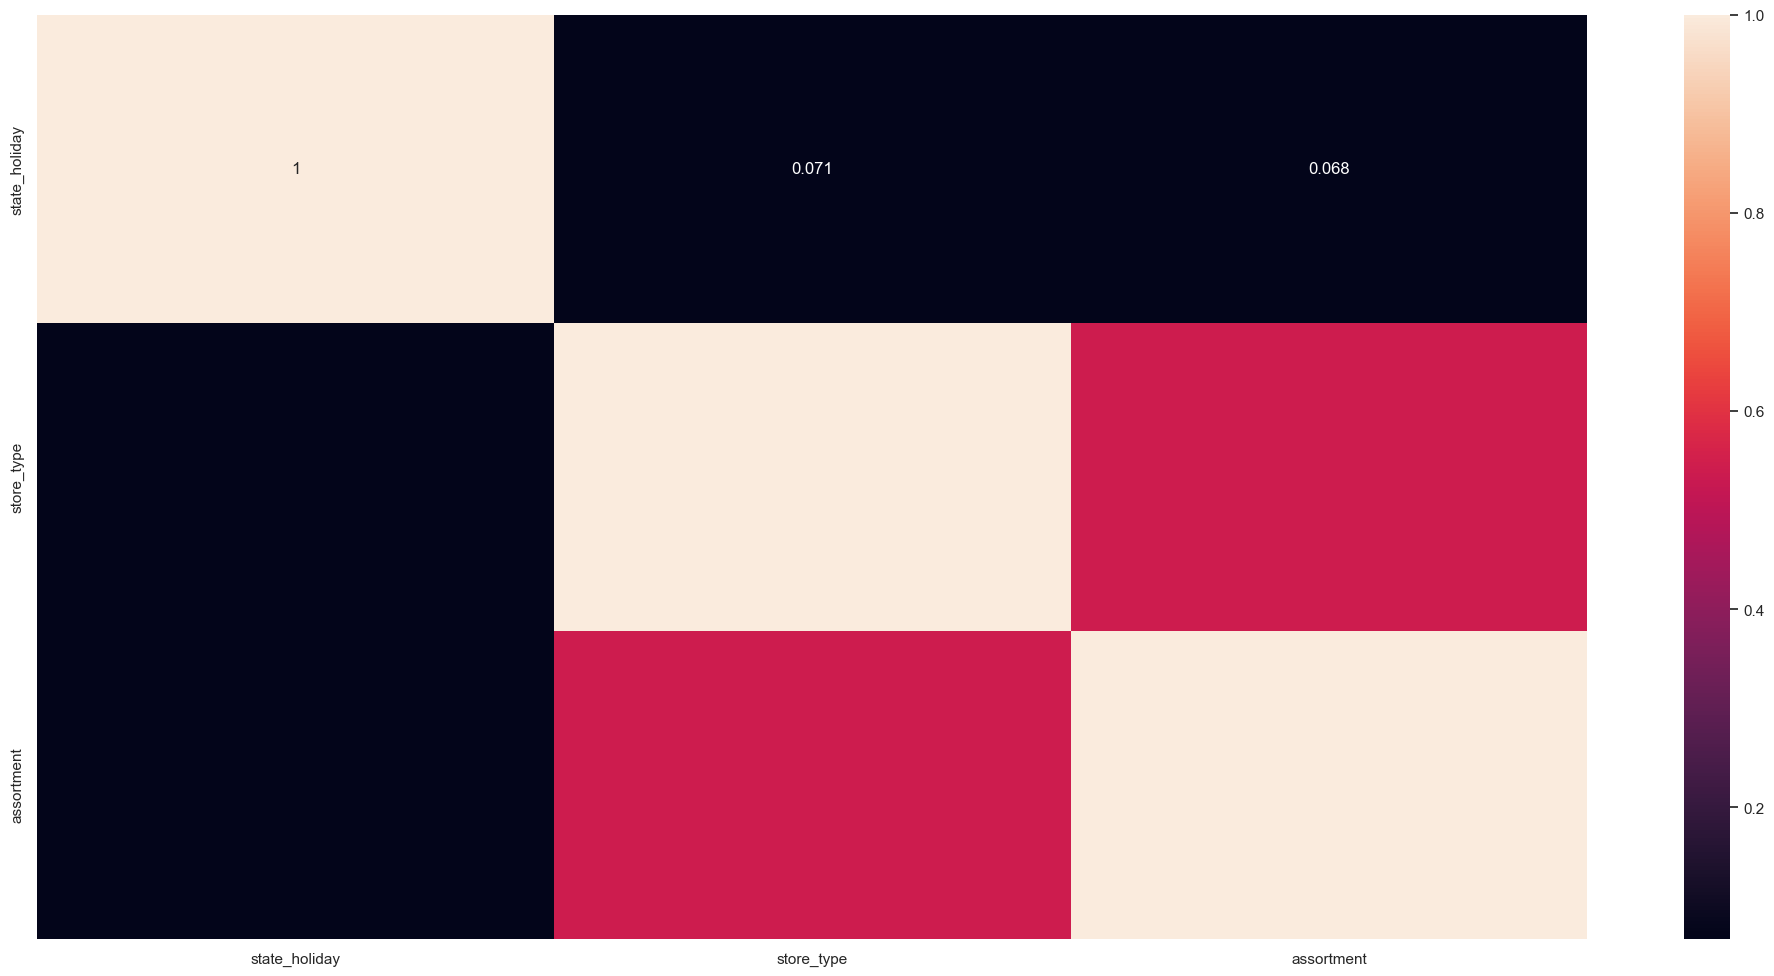

In [50]:
# only categorical data
a = df4.select_dtypes( include="object" )

# Calculate cramer V
a1 = cramer_v (a["state_holiday"], a["state_holiday"])
a2 = cramer_v (a["state_holiday"], a["store_type"])
a3 = cramer_v (a["state_holiday"], a["assortment"])
a4 = cramer_v (a["store_type"], a["state_holiday"])
a5 = cramer_v (a["store_type"], a["store_type"])
a6 = cramer_v (a["store_type"], a["assortment"])
a7 = cramer_v (a["assortment"], a["state_holiday"])
a8 = cramer_v (a["assortment"], a["store_type"])
a9 = cramer_v (a["assortment"], a["assortment"])

# Final dataset
d = pd.DataFrame( {"state_holiday": [a1, a2, a3], "store_type": [a4, a5, a6], "assortment": [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )
plt.show()

## 5.0 Data Preparation

In [51]:
df5 = df4.copy()

### 5.1 Normalizacao

Não aplicamos normalização porque não temos nenhum dado com distribuição normal, cenário ideal para aplicação da técnica.

### 5.2 Rescaling

In [52]:
# df5.dtypes
# a = df5.select_dtypes (include=["float64", "int64", "int32", "uint8"])
# a.head()

# competition_distance, year, competition_time_month, promo_time_week

## Variáveis Ciclícas
# day_of_week, month, day, week_of_year

# sns.boxplot (df5["competition_distance"]) #Temos Outliers
# sns.boxplot (df5["year"])
# sns.boxplot (df5["competition_time_month"]) #Temos Outliers
# sns.boxplot (df5["promo_time_week"]) #Outliers não tão relavantes 
# plt.show()

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()  #sensibilidade alta à Outliers

# competition distance
df5["competition_distance"] = rs.fit_transform( df5[["competition_distance"]].values )
pickle.dump ( rs, open( "parameter/competition_distance_scaler.pkl", "wb") )

# competition time month
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values )
pickle.dump ( rs, open( "parameter/competition_time_month_scaler.pkl", "wb") )

# promo time week
df5["promo_time_week"] = mms.fit_transform( df5[["promo_time_week"]].values )
pickle.dump ( rs, open( "parameter/promo_time_week_scaler.pkl", "wb") )

# year
df5["year"] = mms.fit_transform( df5[["year"]].values )
pickle.dump ( mms, open( "parameter/year_scaler.pkl", "wb") )

### 5.3. Transformation

### 5.3.1 Encoding

In [54]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=["state_holiday"], columns=["state_holiday"] )

# store_type - Label Encoding
le = LabelEncoder()
df5["store_type"] = le.fit_transform( df5["store_type"] )
pickle.dump ( le, open( "parameter/store_type_scaler.pkl", "wb") )

# assortment - Ordinal Encoding
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df5["assortment"] = df5["assortment"].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [55]:
df5["sales"] = np.log1p( df5["sales"] )

In [56]:
# sns.displot (df5["sales"], kde=True)
# plt.show()

### 5.3.3 Nature Transformation

In [57]:
# day of week
df5["day_of_week_sin"] = df5["day_of_week"].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5["day_of_week_cos"] = df5["day_of_week"].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5["month_sin"] = df5["month"].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5["month_cos"] = df5["month"].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5["day_sin"] = df5["day"].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5["day_cos"] = df5["day"].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5["week_of_year_cos"] = df5["week_of_year"].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

## 6.0 Feature Selection

In [58]:
df6 = df5.copy()

### 6.1 Split dataframe into training and test dataset

In [59]:
cols_drop = ["week_of_year", "day", "month", "day_of_week", "promo_since","competition_since", "year_week" ]
df6 = df6.drop( cols_drop, axis=1 )

In [60]:
#data máxima para cada loja e subtrair 42 dias (7 semanas)
# df6[["store", "date"]].groupby ("store").max().reset_index()["date"] - datetime.timedelta(days=7*6)

In [61]:
# training dataset
X_train = df6[df6["date"] < "2015-06-19"]
y_train = X_train["sales"]

# test dataset
X_test = df6[df6["date"] >= "2015-06-19"]
y_test = X_test["sales"]
print( "Training Min Date: {}".format( X_train["date"].min() ) )
print( "Training Max Date: {}".format( X_train["date"].max() ) )
print( "/nTest Min Date: {}".format( X_test["date"].min() ) )
print( "Test Max Date: {}".format( X_test["date"].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
/nTest Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2 Boruta as Feature Selector

In [62]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ["date", "sales"], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators="auto", verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [63]:
# # best features
# cols_selected = boruta.support_.tolist()
# X_train_fs = X_train.drop( ["date", "sales"], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ))

In [64]:
# cols_selected_boruta

### 6.3 Manual Feature Selection

In [65]:
cols_selected_boruta = [
"store",
"promo",
"store_type",
"assortment",
"competition_distance",
"competition_open_since_month",
"competition_open_since_year",
"promo2",
"promo2_since_week",
"promo2_since_year",
"competition_time_month",
"promo_time_week",
"day_of_week_sin",
"day_of_week_cos",
"month_sin",
"month_cos",
"day_sin",
"day_cos",
"week_of_year_sin",
"week_of_year_cos"]

# columns to add
feat_to_add = ["date", "sales"]
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend (feat_to_add)

In [66]:
# cols_selected_boruta_full

## 7.0 Machine Learning Modelling

In [67]:
x_train = X_train [cols_selected_boruta]
x_test = X_test [cols_selected_boruta] 

# Time Series Data Preparation
x_training = X_train [cols_selected_boruta_full]

### 7.1 Average Model

In [68]:
aux1 = x_test.copy()
aux1 ["sales"] = y_test.copy()

# prediction
aux2 = aux1[["store", "sales"]].groupby( "store" ).mean().reset_index().rename(columns={"sales": "predictions"} )
aux1 = pd.merge( aux1, aux2, how="left", on="store" )
yhat_baseline = aux1["predictions"]

# performance
baseline_result = ml_error( "Average Model", np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


**- MAE** (Mean Absolute Error) - Erro Absoluto Médio
**- MAPE** (Mean Absolute Percentage Error) - Erro Percentual Absoluto Médio
**- RMSE** (Root Mean Squared Error) - Raiz do Erro Quadrático Médio

### 7.2 Linear Regression Model

In [69]:
# model
lr = LinearRegression().fit (x_train, y_train)

# prediction
yhat_lr = lr.predict (x_test)

# performance
lr_result = ml_error ( "Linear Regression", np.expm1( y_test ), np.expm1(yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


 ### 7.2.1 Linear Regression Model - Cross Validation

In [70]:
lr_result_cv = cross_validation( x_training, 5, "Linear Regression", lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


 ### 7.3 Linear Regression Regularized Model - Lasso

In [71]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = ml_error( "Linear Regression - Lasso", np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [72]:
lrr_result_cv = cross_validation( x_training, 5, "Lasso", lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.4 Random Forest Regressor

In [73]:
# model
rf = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train)
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( "Random Forest Regressor", np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207


### 7.4.1 Random Forest Regressor - Cross Validation

In [74]:
rf_result_cv = cross_validation (x_training, 5, "Random Forest Regressor", rf,verbose=True)
rf_result_cv

/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26


### 7.5 XGBoost Regressor

In [75]:
# model
model_xgb = xgb.XGBRegressor ( objective="reg:squarederror",
                                n_estimators=1000,
                                eta=0.01,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytree=0.9).fit ( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( "XGBoost Regressor", np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,808.474383,0.117261,1192.638554


 ### 7.5.1 XGBoost Regressor - Cross Validation

In [76]:
xgb_result_cv = cross_validation( x_training, 5, "XGBoost Regressor", model_xgb, verbose=True )
xgb_result_cv

/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,986.61 +/- 165.29,0.14 +/- 0.01,1426.84 +/- 234.43


**Cross Validation** Biblioteca cross_val_score

In [77]:
# xgb_Regressor = xgb.XGBRegressor(objective="reg:squarederror",
#                                     n_estimators=1000,
#                                     eta=0.01,
#                                     max_depth=10,
#                                     subsample=0.7,
#                                     colsample_bytree=0.9)
    
# cross = cross_val_score (xgb_Regressor, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()
# print("RMSE Scores:", cross)

### 7.6 Compare Model’s Performance

### 7.6.1 Single Performance

In [78]:
modelling_result = pd.concat ([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values ("RMSE")

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207
0,XGBoost Regressor,808.474383,0.117261,1192.638554
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [79]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26
0,XGBoost Regressor,986.61 +/- 165.29,0.14 +/- 0.01,1426.84 +/- 234.43


Apesar do Random Forest ser melhor, um projeto de 4 milhoes de linhas pode chegar a 25gb, com uso de 32Mb de memória,
com XGboost, esse mesmo projeto teria o tamnho de 300mb. O Custo com servidor **pode** muitas vezes compensa a diferença de precisão.

## 8.0 Hyperparameter Fine Tuning

### 8.1 Random Search

In [80]:
# param = {
#     "n_estimators": [1500, 1700, 2500, 3000, 3500],
#     "eta": [0.01, 0.03],
#     "max_depth": [3, 5, 9],
#     "subsample": [0.1, 0.5, 0.7],
#     "colsample_bytree": [0.3, 0.7, 0.9],
#     "min_child_weight": [3, 8, 15]
#         }
     
# MAX_EVAL = 5

In [81]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print ( hp )

#     # model
#     model_xgb = xgb.XGBRegressor (objective="reg:squarederror", n_estimators=hp["n_estimators"], eta=hp["eta"], max_depth=hp["max_depth"], subsample=hp["subsample"],
#                                   colsample_bytree=hp["colsample_bytree"], min_child_weight=hp["min_child_weight"] )
    
#     # performance
#     result = cross_validation( x_training, 5, "XGBoost Regressor", model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

{"n_estimators": 3500, "eta": 0.03, "max_depth": 9, "subsample": 0.5, "colsample_bytree": 0.9, "min_child_weight": 15} (1175) /
/
Model Name	MAE CV	MAPE CV	RMSE CV /
0	XGBoost Regressor	812.16 +/- 135.27	0.11 +/- 0.01	1175.97 +/- 201.68 /
0	XGBoost Regressor	1400.65 +/- 138.52	0.19 +/- 0.01	2022.22 +/- 174.59 /
0	XGBoost Regressor	1602.81 +/- 159.29	0.22 +/- 0.01	2313.64 +/- 204.6  /
0	XGBoost Regressor	1315.17 +/- 140.63	0.18 +/- 0.01	1897.64 +/- 180.71 /
0	XGBoost Regressor	845.17 +/- 144.41	0.12 +/- 0.01	1221.3 +/- 210.38  /

### 8.2 Final Model

In [82]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective="reg:squarederror",
                                    n_estimators=1500,
                                    eta=0.03,
                                    max_depth=5,
                                    subsample=0.5,
                                    colsample_bytree=0.9,
                                    min_child_weight=15).fit(x_train, y_train)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict (x_test)

# performance
xgb_result_tuned = ml_error( "XGBoost Regressor", np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,911.945227,0.137934,1318.976678


In [83]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0261118792975172

## 9.0 Traducao e interpretação do Erro

In [84]:
df9 = X_test[ cols_selected_boruta_full ]
# rescale
df9["sales"] = np.expm1( df9["sales"] )
df9["predictions"] = np.expm1( yhat_xgb_tuned )

In [85]:
df9.loc[df9["store"] == 292,:]

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions
23706,292,0,0,1,-0.198387,6,2009,0,28,2015,0.783784,0.287016,-0.974928,-0.222521,-5.000000e-01,-0.866025,8.660254e-01,-0.500000,-2.393157e-01,-0.970942,2015-07-10,1012.0,5676.174316
24821,292,0,0,1,-0.198387,6,2009,0,28,2015,0.783784,0.287016,-0.433884,-0.900969,-5.000000e-01,-0.866025,9.510565e-01,-0.309017,-2.393157e-01,-0.970942,2015-07-09,4777.0,5321.369141
25936,292,0,0,1,-0.198387,6,2009,0,28,2015,0.783784,0.287016,0.433884,-0.900969,-5.000000e-01,-0.866025,9.945219e-01,-0.104528,-2.393157e-01,-0.970942,2015-07-08,2406.0,5416.026855
27051,292,0,0,1,-0.198387,6,2009,0,28,2015,0.783784,0.287016,0.974928,-0.222521,-5.000000e-01,-0.866025,9.945219e-01,0.104528,-2.393157e-01,-0.970942,2015-07-07,3077.0,5499.942383
28166,292,0,0,1,-0.198387,6,2009,0,28,2015,0.783784,0.287016,0.781831,0.623490,-5.000000e-01,-0.866025,9.510565e-01,0.309017,-2.393157e-01,-0.970942,2015-07-06,3754.0,5616.067383
30396,292,0,0,1,-0.198387,6,2009,0,27,2015,0.783784,0.287016,-0.781831,0.623490,-5.000000e-01,-0.866025,7.431448e-01,0.669131,-1.205367e-01,-0.992709,2015-07-04,1646.0,4656.666992
31511,292,1,0,1,-0.198387,6,2009,0,27,2015,0.783784,0.287016,-0.974928,-0.222521,-5.000000e-01,-0.866025,5.877853e-01,0.809017,-1.205367e-01,-0.992709,2015-07-03,5036.0,6799.237305
32626,292,1,0,1,-0.198387,6,2009,0,27,2015,0.783784,0.287016,-0.433884,-0.900969,-5.000000e-01,-0.866025,4.067366e-01,0.913545,-1.205367e-01,-0.992709,2015-07-02,8237.0,7283.451660
33741,292,1,0,1,-0.198387,6,2009,0,27,2015,0.783784,0.287016,0.433884,-0.900969,-5.000000e-01,-0.866025,2.079117e-01,0.978148,-1.205367e-01,-0.992709,2015-07-01,15348.0,7411.379395
34856,292,1,0,1,-0.198387,6,2009,0,27,2015,0.783784,0.287016,0.974928,-0.222521,1.224647e-16,-1.000000,-2.449294e-16,1.000000,-1.205367e-01,-0.992709,2015-06-30,23584.0,8338.137695


 ### 9.1 Business Performance

In [86]:
# sum of predictions
df91 = df9[["store", "predictions"]].groupby( "store" ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[["store", "sales", "predictions"]].groupby( "store" ).apply(lambda x: mean_absolute_error( x["sales"], x["predictions"] ) ).reset_index().rename( columns={0:"MAE"})
df9_aux2 = df9[["store", "sales", "predictions"]].groupby( "store" ).apply(lambda x: mean_absolute_percentage_error( x["sales"], x["predictions"] ) ).reset_index().rename( columns={0:"MAPE"})

# Merge
# Scenarios
# order columns
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how="inner", on="store" )
df92 = pd.merge( df91, df9_aux3, how="inner", on="store" )
df92["worst_scenario"] = df92["predictions"] + (df92["predictions"] * df92["MAPE"])
df92["best_scenario"] = df92["predictions"] - (df92["predictions"] * df92["MAPE"])
df92 = df92[["store", "predictions", "worst_scenario", "best_scenario", "MAE","MAPE"]]

In [87]:
 df92.sort_values( "MAPE", ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,112106.195312,185517.423614,38694.967011,3492.234606,0.654836
908,909,197593.328125,302193.259895,92993.396355,8432.530210,0.529370
472,473,181111.796875,276447.718927,85775.874823,1615.670324,0.526393
901,902,225300.156250,343354.144242,107246.168258,2091.679819,0.523985
285,286,189320.546875,286248.834890,92392.258860,1429.014800,0.511980


<Axes: xlabel='store', ylabel='MAPE'>

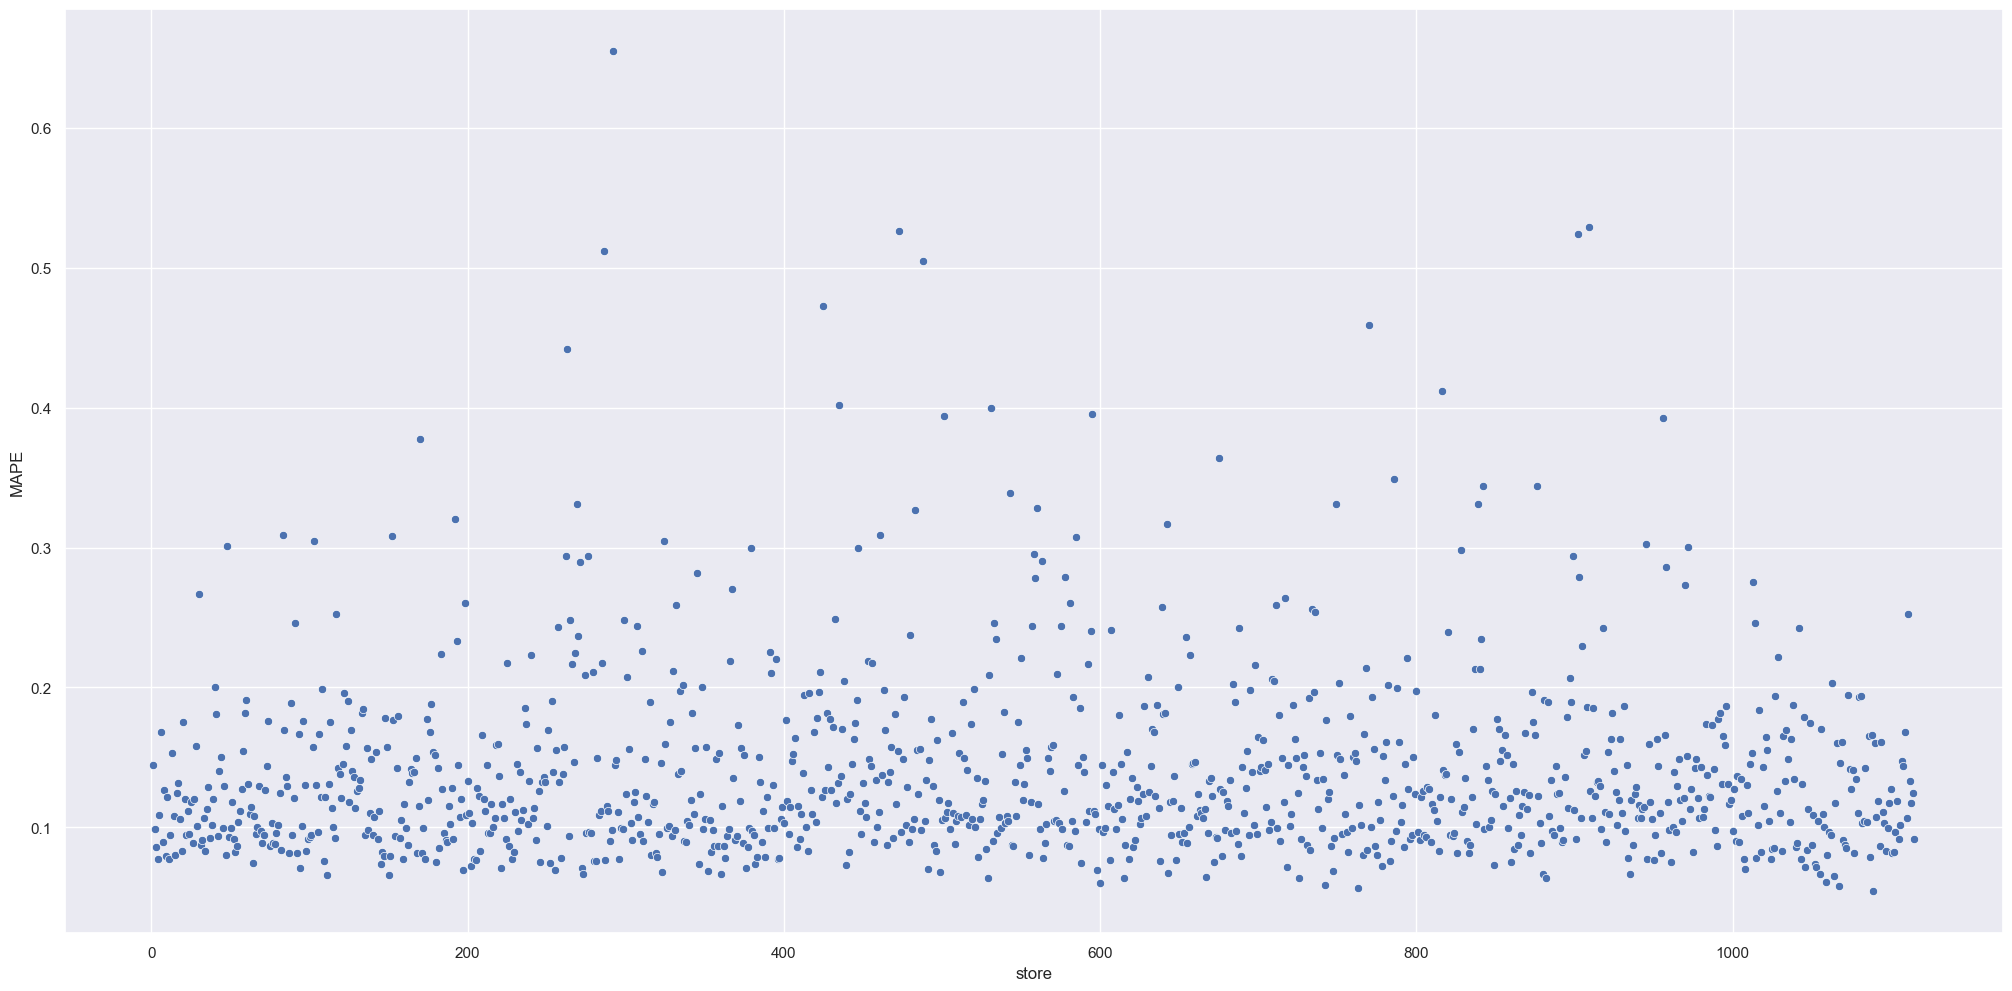

In [88]:
 sns.scatterplot( x="store", y="MAPE", data=df92 )

 ### 9.2 Total Performance

In [89]:
df93 = df92[["predictions", "worst_scenario", "best_scenario"]].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={"index": "Scenario", 0: "Values"} )
df93["Values"] = df93["Values"].map( "R${:,.2f}".format )
df93

,Scenario,Values
0,predictions,"R$284,726,592.00"
1,worst_scenario,"R$323,164,225.98"
2,best_scenario,"R$246,288,974.57"


 ### 9.3 Machine Learning Performance

In [90]:
df9["error"] = df9["sales"]- df9["predictions"]
df9["error_rate"] = df9["predictions"] / df9["sales"]

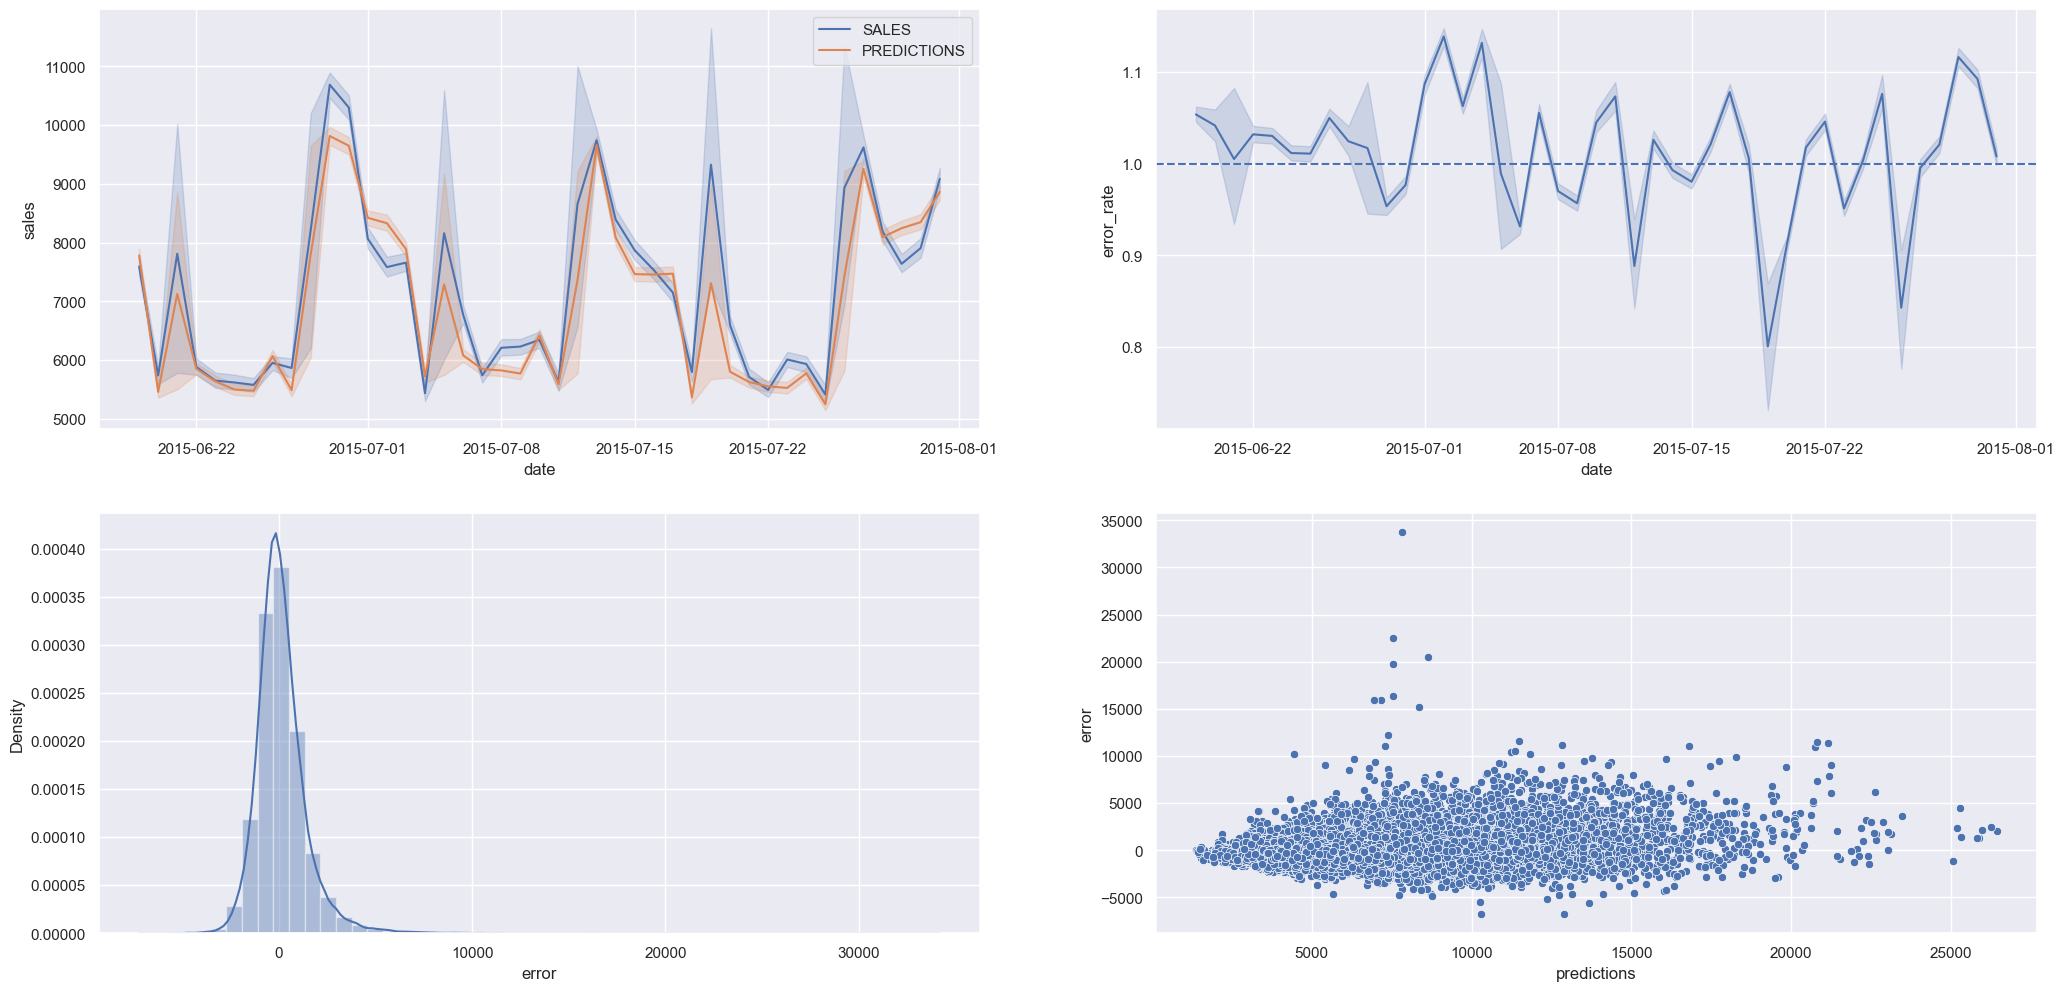

In [91]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x="date", y="sales", data=df9, label="SALES" )
sns.lineplot( x="date", y="predictions", data=df9, label="PREDICTIONS" )

plt.subplot( 2, 2, 2 )
sns.lineplot( x="date", y="error_rate", data=df9 )
plt.axhline( 1, linestyle="--")

plt.subplot( 2, 2, 3 )
sns.distplot( df9["error"] )

plt.subplot( 2, 2, 4 )
# sns.scatterplot( df9["predictions"], df9["error"] )
sns.scatterplot( x=df9["predictions"], y=df9["error"], data=df9 )

plt.show()

## 10.0 Deploy Model To Production

In [92]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( "D:/VivaldoSHermes/Cursos/Comunidade DS/Repos/DS_Projetos/Store_Sales_Prediction/model/model_rossmann.pkl", "wb" ) )

### 10.1. Rossmann Class

In [93]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

In [94]:
class Rossmann( object ):
    def __init__( self ):
        self.home_path="D:/VivaldoSHermes/Cursos/Comunidade DS/Repos/DS_Projetos/Store_Sales_Prediction"
        self.competition_distance_scaler = pickle.load( open( self.home_path + "parameter/competition_distance_scaler.pkl", "rb") )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + "parameter/competition_time_month_scaler.pkl", "rb") )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + "parameter/promo_time_week_scaler.pkl", "rb") )
        self.year_scaler = pickle.load( open( self.home_path + "parameter/year_scaler.pkl", "rb") )
        self.store_type_scaler = pickle.load( open( self.home_path + "parameter/store_type_scaler.pkl", "rb") )
        
    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ["Store", "DayOfWeek", "Date", "Open", "Promo", "StateHoliday", "SchoolHoliday", "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
        "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        # rename
        df1.columns = cols_new
        ## 1.3. Data Types
        df1["date"] = pd.to_datetime( df1["date"] )
        ## 1.5. Fillout NA
        #competition_distance
        df1["competition_distance"] = df1["competition_distance"].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        #competition_open_since_month
        df1["competition_open_since_month"] = df1.apply( lambda x: x["date"]. month if math.isnan( x["competition_open_since_month"] ) else x["competition_open_since_month"], axis=1 )
        #competition_open_since_year
        df1["competition_open_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["competition_open_since_year"] ) else x["competition_open_since_year"], axis=1 )
        #promo2_since_week
        df1["promo2_since_week"] = df1.apply( lambda x: x["date"].week if math.isnan( x["promo2_since_week"] ) else x["promo2_since_week"], axis=1 )
        #promo2_since_year
        df1["promo2_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["promo2_since_year"] ) else x["promo2_since_year"], axis=1 )
        #promo_interval
        month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6:"Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
        df1["promo_interval"].fillna(0, inplace=True )
        df1["month_map"] = df1["date"].dt.month.map( month_map )
        df1["is_promo"] = df1[["promo_interval", "month_map"]].apply( lambda x:0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split( "," ) else 0, axis=1 )
        ## 1.6. Change Data Types
        # competiton
        df1["competition_open_since_month"] = df1["competition_open_since_month"].astype( int )
        df1["competition_open_since_year"] = df1["competition_open_since_year"]. astype( int )
        # promo2
        df1["promo2_since_week"] = df1["promo2_since_week"].astype( int )
        df1["promo2_since_year"] = df1["promo2_since_year"].astype( int )
        return df1
    
    def feature_engineering( self, df2 ):
        # year
        df2["year"] = df2["date"].dt.year
        # month
        df2["month"] = df2["date"].dt.month
        # day
        df2["day"] = df2["date"].dt.day
        # week of year
        df2["week_of_year"] = df2["date"].dt.weekofyear
        # year week
        df2["year_week"] = df2["date"].dt.strftime( "%Y-%W" )
        # competition since
        df2["competition_since"] = df2.apply( lambda x: datetime.datetime( year=x["competition_open_since_year"],month=x["competition_open_since_month"],day=1 ), axis=1 )
        df2["competition_time_month"] = ( ( df2["date"]- df2["competition_since"] )/30 ).apply( lambda x: x.days ).astype( int )
        # promo since
        df2["promo_since"] = df2["promo2_since_year"].astype( str ) + "-" + df2["promo2_since_week"].astype( str )
        df2["promo_since"] = df2["promo_since"].apply( lambda x: datetime.datetime.strptime( x + "-1", "%Y-%W-%w" )- datetime.timedelta( days=7 ) )
        df2["promo_time_week"] = ( ( df2["date"]- df2["promo_since"] )/7 ).apply( lambda x: x.days ).astype( int )
        # assortment
        df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended" )
        # state holiday
        df2["state_holiday"] = df2["state_holiday"].apply( lambda x:"public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day" )
        # 3.0. PASSO 03- FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2["open"] != 0]
        ## 3.2. Selecao das Colunas
        cols_drop = ["open", "promo_interval", "month_map"]
        df2 = df2.drop( cols_drop, axis=1 )
        return df2
    
    def data_preparation( self, df5 ):
        ## 5.2. Rescaling
        # competition distance
        df5["competition_distance"] = self.competition_distance_scaler.fit_transform( df5[["competition_distance"]].values )
        # competition time month
        df5["competition_time_month"] = self.competition_time_month_scaler.fit_transform( df5[["competition_time_month"]].values )
        # promo time week
        df5["promo_time_week"] = self.promo_time_week_scaler.fit_transform(df5[["promo_time_week"]].values )
        # year
        df5["year"] = self.year_scaler.fit_transform( df5[["year"]].values )
        ### 5.3.1. Encoding
        # state_holiday- One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=["state_holiday"],columns=["state_holiday"] )
        # store_type- Label Encoding
        df5["store_type"] = self.store_type_scaler.fit_transform(df5["store_type"] )
        # assortment- Ordinal Encoding
        assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
        df5["assortment"] = df5["assortment"].map( assortment_dict )
        ### 5.3.3. Nature Transformation
        # day of week
        df5["day_of_week_sin"] = df5["day_of_week"].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5["day_of_week_cos"] = df5["day_of_week"].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        # month
        df5["month_sin"] = df5["month"].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5["month_cos"] = df5["month"].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        # day
        df5["day_sin"] = df5["day"].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5["day_cos"] = df5["day"].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        # week of year
        df5["week_of_year_sin"] = df5["week_of_year"].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
        df5["week_of_year_cos"] = df5["week_of_year"].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )
        cols_selected = [ "store", "promo", "store_type", "assortment","competition_distance", "competition_open_since_month",
        "competition_open_since_year", "promo2", "promo2_since_week","promo2_since_year", "competition_time_month", "promo_time_week",
        "day_of_week_sin", "day_of_week_cos", "month_sin", "month_cos","day_sin", "day_cos", "week_of_year_sin", "week_of_year_cos"]
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        # join pred into the original data
        original_data["prediction"] = np.expm1( pred )
        return original_data.to_json( orient="records", date_format="iso" )

### 10.2 API Handler

In [95]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
# loading model
# initialize API
app = Flask( __name__ )
model = pickle.load( open( "D:/VivaldoSHermes/Cursos/Comunidade DS/Repos/DS_Projetos/Store_Sales_Prediction/model/model_rossmann.pkl", "rb") )
@app.route( "/rossmann/predict", methods=["POST"] )

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            # Instantiate Rossmann class
            pipeline = Rossmann()
            # data cleaning
            df1 = pipeline.data_cleaning( test_raw )
            # feature engineering
            df2 = pipeline.feature_engineering( df1 )
            # data preparation
            df3 = pipeline.data_preparation( df2 )
            # prediction
            df_response = pipeline.get_prediction( model, test_raw, df3 )
        return df_response
    else:
        return Reponse( "{}", status=200, mimetype="application/json" )
if __name__ == "__main__":
    app.run( "0.0.0.0" )

ModuleNotFoundError: No module named 'rossmann'

### 10.3 API Tester

In [96]:
# loading test dataset
df10 = pd.read_csv( "D:/VivaldoSHermes/Cursos/Comunidade DS/Repos/DS_Projetos/Store_Sales_Prediction/Rossmann Store Sales/test.csv" )

In [97]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how="left", on="Store" )

# choose store for prediction
df_test = df_test[df_test["Store"].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test["Open"] != 0]
df_test = df_test[~df_test["Open"].isnull()]
df_test = df_test.drop( "Id", axis=1 )

In [98]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient="records" ) )

In [103]:
# API Call
url = 'http://10.0.0.105:5000/rossmann/predict'
# url = 'https://store-sales-prediction-webapp.onrender.com'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [104]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [105]:
d2 = d1[["store", "prediction"]].groupby( "store" ).sum().reset_index()
for i in range( len( d2 ) ):
    print( "Store Number {} will sell R${:,.2f} in the next 6 weeks".format(
    d2.loc[i, "store"],
    d2.loc[i, "prediction"] ) )

Store Number 20 will sell R$291,739.46 in the next 6 weeks
Store Number 22 will sell R$231,037.37 in the next 6 weeks
Store Number 23 will sell R$229,752.25 in the next 6 weeks
